In [2]:
# Celda 1: Montar Drive y preparar rutas
from google.colab import drive
drive.mount('/content/drive')

BASE_DIR   = Path("/content/drive/MyDrive/CognitivaAI")
DATA_DIR   = BASE_DIR / "oas1_data"
OUT_DIR    = BASE_DIR / "ft_effb3_stable_colab_plus"
GRAPHS_DIR = OUT_DIR / "graphs_from_metrics"
OUT_DIR.mkdir(parents=True, exist_ok=True)
GRAPHS_DIR.mkdir(parents=True, exist_ok=True)

VAL_MAP  = DATA_DIR / "oas1_val_colab_mapped.csv"
TEST_MAP = DATA_DIR / "oas1_test_colab_mapped.csv"

print("Device:", "cuda" if torch.cuda.is_available() else "cpu")
print("Mounted at /content/drive")
print("BASE   :", BASE_DIR)
print("DATA   :", DATA_DIR, "| exists:", DATA_DIR.exists())
print("OUT    :", OUT_DIR)
print("GRAPHS :", GRAPHS_DIR)
print("VAL_MAP:", VAL_MAP, "| exists:", VAL_MAP.exists())
print("TEST_MAP:", TEST_MAP, "| exists:", TEST_MAP.exists())


Mounted at /content/drive
Device: cuda
Mounted at /content/drive
BASE   : /content/drive/MyDrive/CognitivaAI
DATA   : /content/drive/MyDrive/CognitivaAI/oas1_data | exists: True
OUT    : /content/drive/MyDrive/CognitivaAI/ft_effb3_stable_colab_plus
GRAPHS : /content/drive/MyDrive/CognitivaAI/ft_effb3_stable_colab_plus/graphs_from_metrics
VAL_MAP: /content/drive/MyDrive/CognitivaAI/oas1_data/oas1_val_colab_mapped.csv | exists: True
TEST_MAP: /content/drive/MyDrive/CognitivaAI/oas1_data/oas1_test_colab_mapped.csv | exists: True


In [3]:
# Celda 2: Configuración y lectura de CSV estándar (mapped => patient_id, target, png_path)

@dataclass
class CFG:
    img_size: int = 300
    batch_size: int = 64
    num_workers: int = 2
    seeds: tuple = (41, 42, 43)    # ensemble de 3 seeds
    holdout_patients: int = 10     # desde VAL asignamos 10 pacientes a holdout (como en P9)

@dataclass
class TrainCfg:
    epochs: int = 8
    lr: float = 1e-4
    wd: float = 1e-5
    amp: bool = True
    patience: int = 3
    label_smoothing: float = 0.05   # Mejora 1: label smoothing
    use_pos_weight: bool = True    # Alternativa a smoothing (déjalo False si usas smoothing)
    pos_weight: float = 1.5

cfg = CFG()
tcfg = TrainCfg()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def load_mapped_csv(path: Path) -> pd.DataFrame:
    df = pd.read_csv(path)
    cols = [c.lower() for c in df.columns]
    df.columns = cols
    # Esperamos 'patient_id', 'target', 'png_path'
    assert all([c in df.columns for c in ["patient_id","target","png_path"]]), f"CSV {path} debe tener patient_id,target,png_path"
    df = df.rename(columns={"target":"y_true"})
    df["y_true"] = df["y_true"].astype(int)
    return df

val_map  = load_mapped_csv(VAL_MAP)
test_map = load_mapped_csv(TEST_MAP)

# Split train/holdout desde VAL por pacientes
patients = val_map["patient_id"].unique()
rng = np.random.default_rng(42)
rng.shuffle(patients)
holdout_pat = set(patients[:cfg.holdout_patients])

train_df   = val_map[~val_map["patient_id"].isin(holdout_pat)].reset_index(drop=True)
holdout_df = val_map[ val_map["patient_id"].isin(holdout_pat)].reset_index(drop=True)
test_df    = test_map.copy().reset_index(drop=True)

def summarize_df(df, name):
    print(f"{name}: shape={df.shape}, pacientes={df['patient_id'].nunique()}, y_mean={df['y_true'].mean():.3f}")

print("CFG", cfg)
summarize_df(val_map, "VAL mapeado")
summarize_df(test_df, "TEST mapeado")
summarize_df(train_df, "train_df")
summarize_df(holdout_df, "holdout_df")
summarize_df(test_df, "test_df")

print("\nEjemplo train_df:"); display(train_df.head(3))
print("\nEjemplo holdout_df:"); display(holdout_df.head(3))
print("\nEjemplo test_df:"); display(test_df.head(3))

CFG CFG(img_size=300, batch_size=64, num_workers=2, seeds=(41, 42, 43), holdout_patients=10)
VAL mapeado: shape=(940, 6), pacientes=47, y_mean=0.426
TEST mapeado: shape=(940, 6), pacientes=47, y_mean=0.426
train_df: shape=(740, 6), pacientes=37, y_mean=0.459
holdout_df: shape=(200, 6), pacientes=10, y_mean=0.300
test_df: shape=(940, 6), pacientes=47, y_mean=0.426

Ejemplo train_df:


,png_path,y_true,patient_id,scan_id,source_hdr,has_mask
0,/content/drive/MyDrive/CognitivaAI/oas1_data/O...,1,OAS1_0003,OAS1_0003_MR1,DATA\OAS1_RAW\OAS1_0003_MR1\RAW\OAS1_0003_MR1_...,1
1,/content/drive/MyDrive/CognitivaAI/oas1_data/O...,1,OAS1_0003,OAS1_0003_MR1,DATA\OAS1_RAW\OAS1_0003_MR1\RAW\OAS1_0003_MR1_...,1
2,/content/drive/MyDrive/CognitivaAI/oas1_data/O...,1,OAS1_0003,OAS1_0003_MR1,DATA\OAS1_RAW\OAS1_0003_MR1\RAW\OAS1_0003_MR1_...,1



Ejemplo holdout_df:


,png_path,y_true,patient_id,scan_id,source_hdr,has_mask
0,/content/drive/MyDrive/CognitivaAI/oas1_data/O...,1,OAS1_0022,OAS1_0022_MR1,DATA\OAS1_RAW\OAS1_0022_MR1\RAW\OAS1_0022_MR1_...,1
1,/content/drive/MyDrive/CognitivaAI/oas1_data/O...,1,OAS1_0022,OAS1_0022_MR1,DATA\OAS1_RAW\OAS1_0022_MR1\RAW\OAS1_0022_MR1_...,1
2,/content/drive/MyDrive/CognitivaAI/oas1_data/O...,1,OAS1_0022,OAS1_0022_MR1,DATA\OAS1_RAW\OAS1_0022_MR1\RAW\OAS1_0022_MR1_...,1



Ejemplo test_df:


,png_path,y_true,patient_id,scan_id,source_hdr,has_mask
0,/content/drive/MyDrive/CognitivaAI/oas1_data/O...,0,OAS1_0002,OAS1_0002_MR1,DATA\OAS1_RAW\OAS1_0002_MR1\RAW\OAS1_0002_MR1_...,1
1,/content/drive/MyDrive/CognitivaAI/oas1_data/O...,0,OAS1_0002,OAS1_0002_MR1,DATA\OAS1_RAW\OAS1_0002_MR1\RAW\OAS1_0002_MR1_...,1
2,/content/drive/MyDrive/CognitivaAI/oas1_data/O...,0,OAS1_0002,OAS1_0002_MR1,DATA\OAS1_RAW\OAS1_0002_MR1\RAW\OAS1_0002_MR1_...,1


In [7]:
# Celda 3: Dataset + Dataloaders con RandAugment suave y normalización simple

from torchvision.transforms import RandAugment, ColorJitter

class MRISliceDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self): return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row["png_path"]).convert("RGB")  # RGB para EffNet
        if self.transform is not None:
            img = self.transform(img)
        y = float(row["y_true"])
        return img, torch.tensor([y], dtype=torch.float32), row["patient_id"]

# Transforms
train_tf = T.Compose([
    T.Resize((cfg.img_size, cfg.img_size)),
    RandAugment(num_ops=2, magnitude=5),         # Mejora 1: RandAugment suave
    ColorJitter(brightness=0.05, contrast=0.05),
    T.ToTensor(),
    T.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5]),
])
val_tf = T.Compose([
    T.Resize((cfg.img_size, cfg.img_size)),
    T.ToTensor(),
    T.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5]),
])

train_ds   = MRISliceDataset(train_df,   transform=train_tf)
holdout_ds = MRISliceDataset(holdout_df, transform=val_tf)
test_ds    = MRISliceDataset(test_df,    transform=val_tf)

def make_loader(ds, shuffle, bs=cfg.batch_size):
    return DataLoader(ds, batch_size=bs, shuffle=shuffle, num_workers=cfg.num_workers, pin_memory=True)

train_loader   = make_loader(train_ds, shuffle=True)
holdout_loader = make_loader(holdout_ds, shuffle=False)
test_loader    = make_loader(test_ds, shuffle=False)

print("Loaders creados. Batches train/holdout/test:",
      len(train_loader), len(holdout_loader), len(test_loader))


Loaders creados. Batches train/holdout/test: 12 4 15


In [8]:
# Celda 4: Modelo EffNet-B3 + loss (label smoothing) + AdamW + warmup+cosine + AMP + early stopping

def create_model(num_classes=1):
    model = timm.create_model("tf_efficientnet_b3_ns", pretrained=True, in_chans=3, num_classes=num_classes)
    return model

def create_loss():
    if tcfg.use_pos_weight:
        pw = torch.tensor([tcfg.pos_weight], device=device)
        return nn.BCEWithLogitsLoss(pos_weight=pw)
    else:
        # Removed label_smoothing due to TypeError. Using pos_weight instead.
        return nn.BCEWithLogitsLoss()

def cosine_with_warmup(optimizer, total_steps, warmup_ratio=0.1):
    warmup_steps = max(1, int(total_steps * warmup_ratio))
    def lr_lambda(current_step):
        if current_step < warmup_steps:
            return float(current_step) / float(max(1, warmup_steps))
        # Cosine decay hasta 0
        progress = (current_step - warmup_steps) / float(max(1, total_steps - warmup_steps))
        return 0.5 * (1.0 + math.cos(math.pi * progress))
    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

def evaluate_auc_pr(model, loader):
    model.eval()
    all_logits, all_y = [], []
    with torch.no_grad(), torch.amp.autocast('cuda', enabled=(device.type=="cuda" and tcfg.amp)):
        for x, y, _ in loader:
            x = x.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)
            logits = model(x)
            all_logits.append(logits.detach().float().cpu())
            all_y.append(y.detach().float().cpu())
    all_logits = torch.cat(all_logits, 0).squeeze(1).numpy()
    all_y = torch.cat(all_y, 0).squeeze(1).numpy()
    probs = 1/(1+np.exp(-all_logits))
    auc  = roc_auc_score(all_y, probs) if len(np.unique(all_y))>1 else np.nan
    pr   = average_precision_score(all_y, probs) if len(np.unique(all_y))>1 else np.nan
    return auc, pr

def train_one_seed(seed, train_loader, holdout_loader):
    set_seed(seed)
    model = create_model().to(device)
    loss_fn = create_loss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=tcfg.lr, weight_decay=tcfg.wd)

    total_steps = tcfg.epochs * len(train_loader)
    scheduler = cosine_with_warmup(optimizer, total_steps, warmup_ratio=0.1)
    scaler = torch.amp.GradScaler('cuda', enabled=(device.type=="cuda" and tcfg.amp))

    best_auc = -1.0
    best_path = OUT_DIR / f"effb3_plus_seed{seed}.pth"
    history = []
    no_improve = 0

    print(f"Seed {seed} | Epochs={tcfg.epochs} | steps/epoch={len(train_loader)}")
    step = 0
    for epoch in range(1, tcfg.epochs+1):
        model.train()
        losses = []
        pbar = tqdm(train_loader, desc=f"Seed {seed} | Epoch {epoch}/{tcfg.epochs}", leave=False)
        for x, y, _ in pbar:
            x = x.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)
            optimizer.zero_grad(set_to_none=True)
            with torch.amp.autocast('cuda', enabled=(device.type=="cuda" and tcfg.amp)):
                logits = model(x).squeeze(1)
                loss = loss_fn(logits, y.squeeze(1))
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
            losses.append(loss.item())
            step += 1
            pbar.set_postfix(loss=np.mean(losses))

        val_auc, val_pr = evaluate_auc_pr(model, holdout_loader)
        history.append({"epoch":epoch, "loss":float(np.mean(losses)), "holdout_auc":float(val_auc), "holdout_pr":float(val_pr)})
        print(f"  -> Holdout AUC={val_auc:.3f} | PR-AUC={val_pr:.3f} | loss={np.mean(losses):.4f}")

        if val_auc > best_auc:
            best_auc = val_auc
            torch.save(model.state_dict(), best_path)
            print(f"  💾 Nuevo mejor checkpoint (seed {seed}) en: {best_path} | Holdout AUC={best_auc:.3f}")
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= tcfg.patience:
                print("  ⏹️ Early stopping por paciencia.")
                break

    # guardar historia
    hist_path = OUT_DIR / f"train_history_plus_seed{seed}.json"
    with open(hist_path, "w") as f:
        json.dump(history, f, indent=2)
    return str(best_path), best_auc

In [9]:
# Celda 5: Entrenar varias seeds y elegir el mejor por AUC holdout
ckpts = []
for sd in cfg.seeds:
    bp, auc_h = train_one_seed(sd, train_loader, holdout_loader)
    ckpts.append({"seed":sd, "ckpt":bp, "holdout_auc":float(auc_h)})

ckpts_sorted = sorted(ckpts, key=lambda d: d["holdout_auc"], reverse=True)
best = ckpts_sorted[0]
BEST_CKPT = OUT_DIR / "best_effb3_stable_plus.pth"
shutil.copyfile(best["ckpt"], BEST_CKPT)

print("✅ Checkpoints:", [c["ckpt"] for c in ckpts_sorted])
print("🏆 Mejor:", best)
print("➡️ Copiado como BEST:", BEST_CKPT)

with open(OUT_DIR/"train_history_stable_plus_summary.json","w") as f:
    json.dump({"candidates":ckpts_sorted, "best":best, "best_ckpt":str(BEST_CKPT)}, f, indent=2)


/usr/local/lib/python3.12/dist-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name tf_efficientnet_b3_ns to current tf_efficientnet_b3.ns_jft_in1k.
  model = create_fn(


Seed 41 | Epochs=8 | steps/epoch=12


Seed 41 | Epoch 1/8:   0%|          | 0/12 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


  -> Holdout AUC=0.431 | PR-AUC=0.293 | loss=1.4411
  💾 Nuevo mejor checkpoint (seed 41) en: /content/drive/MyDrive/CognitivaAI/ft_effb3_stable_colab_plus/effb3_plus_seed41.pth | Holdout AUC=0.431


  -> Holdout AUC=0.385 | PR-AUC=0.259 | loss=0.7813


  -> Holdout AUC=0.410 | PR-AUC=0.264 | loss=0.4799


  -> Holdout AUC=0.437 | PR-AUC=0.286 | loss=0.3659
  💾 Nuevo mejor checkpoint (seed 41) en: /content/drive/MyDrive/CognitivaAI/ft_effb3_stable_colab_plus/effb3_plus_seed41.pth | Holdout AUC=0.437


  -> Holdout AUC=0.459 | PR-AUC=0.298 | loss=0.2786
  💾 Nuevo mejor checkpoint (seed 41) en: /content/drive/MyDrive/CognitivaAI/ft_effb3_stable_colab_plus/effb3_plus_seed41.pth | Holdout AUC=0.459


  -> Holdout AUC=0.372 | PR-AUC=0.257 | loss=0.2042


  -> Holdout AUC=0.397 | PR-AUC=0.262 | loss=0.1659


  -> Holdout AUC=0.385 | PR-AUC=0.248 | loss=0.1780
  ⏹️ Early stopping por paciencia.


/usr/local/lib/python3.12/dist-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name tf_efficientnet_b3_ns to current tf_efficientnet_b3.ns_jft_in1k.
  model = create_fn(


Seed 42 | Epochs=8 | steps/epoch=12


Seed 42 | Epoch 1/8:   0%|          | 0/12 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


  -> Holdout AUC=0.527 | PR-AUC=0.363 | loss=1.3326
  💾 Nuevo mejor checkpoint (seed 42) en: /content/drive/MyDrive/CognitivaAI/ft_effb3_stable_colab_plus/effb3_plus_seed42.pth | Holdout AUC=0.527


  -> Holdout AUC=0.432 | PR-AUC=0.299 | loss=0.8189


  -> Holdout AUC=0.387 | PR-AUC=0.256 | loss=0.4927


  -> Holdout AUC=0.388 | PR-AUC=0.262 | loss=0.3192
  ⏹️ Early stopping por paciencia.


/usr/local/lib/python3.12/dist-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name tf_efficientnet_b3_ns to current tf_efficientnet_b3.ns_jft_in1k.
  model = create_fn(


Seed 43 | Epochs=8 | steps/epoch=12


Seed 43 | Epoch 1/8:   0%|          | 0/12 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


  -> Holdout AUC=0.475 | PR-AUC=0.312 | loss=1.2818
  💾 Nuevo mejor checkpoint (seed 43) en: /content/drive/MyDrive/CognitivaAI/ft_effb3_stable_colab_plus/effb3_plus_seed43.pth | Holdout AUC=0.475


  -> Holdout AUC=0.491 | PR-AUC=0.317 | loss=0.7585
  💾 Nuevo mejor checkpoint (seed 43) en: /content/drive/MyDrive/CognitivaAI/ft_effb3_stable_colab_plus/effb3_plus_seed43.pth | Holdout AUC=0.491


  -> Holdout AUC=0.497 | PR-AUC=0.366 | loss=0.4549
  💾 Nuevo mejor checkpoint (seed 43) en: /content/drive/MyDrive/CognitivaAI/ft_effb3_stable_colab_plus/effb3_plus_seed43.pth | Holdout AUC=0.497


  -> Holdout AUC=0.507 | PR-AUC=0.363 | loss=0.3359
  💾 Nuevo mejor checkpoint (seed 43) en: /content/drive/MyDrive/CognitivaAI/ft_effb3_stable_colab_plus/effb3_plus_seed43.pth | Holdout AUC=0.507


  -> Holdout AUC=0.520 | PR-AUC=0.352 | loss=0.2629
  💾 Nuevo mejor checkpoint (seed 43) en: /content/drive/MyDrive/CognitivaAI/ft_effb3_stable_colab_plus/effb3_plus_seed43.pth | Holdout AUC=0.520


  -> Holdout AUC=0.440 | PR-AUC=0.300 | loss=0.2644


  -> Holdout AUC=0.487 | PR-AUC=0.343 | loss=0.2122


  -> Holdout AUC=0.450 | PR-AUC=0.291 | loss=0.1965
  ⏹️ Early stopping por paciencia.
✅ Checkpoints: ['/content/drive/MyDrive/CognitivaAI/ft_effb3_stable_colab_plus/effb3_plus_seed42.pth', '/content/drive/MyDrive/CognitivaAI/ft_effb3_stable_colab_plus/effb3_plus_seed43.pth', '/content/drive/MyDrive/CognitivaAI/ft_effb3_stable_colab_plus/effb3_plus_seed41.pth']
🏆 Mejor: {'seed': 42, 'ckpt': '/content/drive/MyDrive/CognitivaAI/ft_effb3_stable_colab_plus/effb3_plus_seed42.pth', 'holdout_auc': 0.5273214285714286}
➡️ Copiado como BEST: /content/drive/MyDrive/CognitivaAI/ft_effb3_stable_colab_plus/best_effb3_stable_plus.pth


In [10]:
# Celda 6: Inferencia con TTA + ensemble opcional + pooling por paciente (mean y top-k mean)

def load_model_from_ckpt(ckpt_path: Path):
    m = create_model().to(device)
    sd = torch.load(ckpt_path, map_location=device)
    m.load_state_dict(sd)
    m.eval()
    return m

def tta_logits(model, x):
    # 4 vistas: original, flip H, flip V, rot90
    outs = []
    outs.append(model(x))
    outs.append(model(torch.flip(x, dims=[-1])))
    outs.append(model(torch.flip(x, dims=[-2])))
    outs.append(model(torch.rot90(x, k=1, dims=[-2, -1])))
    return torch.stack(outs, dim=0).mean(dim=0)

@torch.no_grad()
def predict_slices(models, loader, use_tta=True):
    all_rows = []
    for x, y, pids in tqdm(loader, desc="Inferencia slices", leave=False):
        x = x.to(device, non_blocking=True)
        # Ensemble: media de logits de todos los modelos
        logits_list = []
        for m in models:
            if use_tta:
                logits_list.append(tta_logits(m, x))
            else:
                logits_list.append(m(x))
        logits = torch.stack(logits_list, 0).mean(0).squeeze(1)
        probs = torch.sigmoid(logits).float().cpu().numpy()
        yb = y.squeeze(1).float().cpu().numpy()
        for pid, yy, pp in zip(pids, yb, probs):
            all_rows.append((pid, int(yy), float(pp)))
    df = pd.DataFrame(all_rows, columns=["patient_id","y_true","y_score"])
    return df

def pool_patient_mean(df_slices: pd.DataFrame) -> pd.DataFrame:
    return (df_slices
            .groupby("patient_id")
            .agg(y_true=("y_true","max"), y_score=("y_score","mean"))
            .reset_index())

def pool_patient_topk_mean(df_slices: pd.DataFrame, k:int=5) -> pd.DataFrame:
    # Ordena por score y toma las k mejores por paciente, promedio
    df_sorted = df_slices.sort_values("y_score", ascending=False)
    df_topk = (df_sorted.groupby("patient_id").head(k)
               .groupby("patient_id")
               .agg(y_true=("y_true","max"), y_score=("y_score","mean"))
               .reset_index())
    return df_topk


In [11]:
# Celda 7: Fit de Temperature Scaling (T) en HOLDOUT y selección de umbral por recall deseado en VAL (holdout)

from scipy.optimize import minimize

def fit_temperature(logits: np.ndarray, y_true: np.ndarray, init_T=1.0):
    # Minimizar NLL (log-loss) para encontrar T
    def nll(T):
        T = float(np.maximum(T, 1e-3))
        z = logits / T
        p = 1/(1+np.exp(-z))
        eps = 1e-8
        return -np.mean(y_true*np.log(p+eps) + (1-y_true)*np.log(1-p+eps))
    res = minimize(lambda t: nll(t[0]), x0=np.array([init_T]), method="Nelder-Mead")
    best_T = float(np.maximum(res.x[0], 1e-3))
    return best_T

def choose_threshold_by_recall(y_true, y_score, recall_floor=0.90):
    # barremos thresholds y elegimos el más bajo que cumple recall >= floor
    thr_space = np.linspace(0, 1, 1001)
    for thr in thr_space:
        yhat = (y_score >= thr).astype(int)
        r = recall_score(y_true, yhat, zero_division=0)
        if r >= recall_floor:
            return float(thr)
    # si no se cumple, devolver el que max recall produce (o 0.5 fallback)
    recalls = [(recall_score(y_true, (y_score>=thr).astype(int), zero_division=0), thr) for thr in thr_space]
    best = max(recalls, key=lambda t:t[0])[1]
    return float(best)


In [12]:
# Celda 8: Cargar modelos (ensemble), inferencia VAL/TEST, calibrar T en holdout, pooling top-k, métricas y guardado

# 1) Cargar modelos del ensemble
ckpt_paths = [Path(c["ckpt"]) for c in ckpts]  # de Celda 5
models = [load_model_from_ckpt(p) for p in ckpt_paths]

# 2) Inferencia por slices en HOLDOUT (para calibrar T)
#    Para calibrar con logits, volvemos a obtener logits medios sin sigmoid:
@torch.no_grad()
def predict_slice_logits(models, loader, use_tta=True):
    all_logits, all_y = [], []
    for x, y, pids in tqdm(loader, desc="Inferencia logits (holdout)", leave=False):
        x = x.to(device, non_blocking=True)
        ll = []
        for m in models:
            if use_tta:
                ll.append(tta_logits(m, x).squeeze(1))
            else:
                ll.append(m(x).squeeze(1))
        logits = torch.stack(ll, 0).mean(0).float().cpu().numpy()
        all_logits.append(logits)
        all_y.append(y.squeeze(1).float().cpu().numpy())
    return np.concatenate(all_logits, 0), np.concatenate(all_y, 0)

hold_logits_s, hold_y_s = predict_slice_logits(models, holdout_loader, use_tta=True)
# Pooling mean (logits -> probs después de T)
# Para ajustar T, usamos logits a nivel slice; es suficientemente informativo
best_T = fit_temperature(hold_logits_s, hold_y_s, init_T=1.0)
print(f"🧪 Temperature scaling ajustado en HOLDOUT: T={best_T:.4f}")

# 3) Inferencia completa (VAL split = train+holdout) y TEST a nivel slice -> pasar a nivel paciente
val_slices = predict_slices(models, DataLoader(MRISliceDataset(val_map, transform=val_tf),
                                               batch_size=cfg.batch_size, shuffle=False,
                                               num_workers=cfg.num_workers, pin_memory=True),
                            use_tta=True)
test_slices = predict_slices(models, test_loader, use_tta=True)

def apply_temperature_inplace(df_slices, T):
    # Convertimos y_score a logits, dividimos por T y re-sigmoid
    p = np.clip(df_slices["y_score"].values, 1e-6, 1-1e-6)
    logits = np.log(p/(1-p))
    pT = 1/(1+np.exp(-(logits/T)))
    df_slices["y_score"] = pT
    return df_slices

val_slices_T  = apply_temperature_inplace(val_slices.copy(), best_T)
test_slices_T = apply_temperature_inplace(test_slices.copy(), best_T)

# Pooling por paciente: mean y top-k mean
VAL_MEAN   = pool_patient_mean(val_slices_T)
VAL_TOPK   = pool_patient_topk_mean(val_slices_T, k=5)
TEST_MEAN  = pool_patient_mean(test_slices_T)
TEST_TOPK  = pool_patient_topk_mean(test_slices_T, k=5)

# 4) Elegir umbral por recall en VAL (elige set: mean o top-k)
val_choice = VAL_TOPK    # ← usa TOP-K; si prefieres mean, cambia aquí
thr = choose_threshold_by_recall(val_choice["y_true"].values, val_choice["y_score"].values, recall_floor=0.90)
print(f"🎯 Umbral elegido (VAL, recall≥0.90): thr={thr:.4f}")

def compute_metrics(y, p, thr):
    yhat = (p>=thr).astype(int)
    return {
        "AUC":   float(roc_auc_score(y, p)) if len(np.unique(y))>1 else float('nan'),
        "PR-AUC":float(average_precision_score(y, p)) if len(np.unique(y))>1 else float('nan'),
        "Acc":   float(accuracy_score(y, yhat)),
        "P":     float(precision_score(y, yhat, zero_division=0)),
        "R":     float(recall_score(y, yhat, zero_division=0)),
        "thr":   float(thr),
        "n":     int(len(y)),
    }

VAL_MET  = compute_metrics(VAL_TOPK["y_true"].values,  VAL_TOPK["y_score"].values,  thr)
TEST_MET = compute_metrics(TEST_TOPK["y_true"].values, TEST_TOPK["y_score"].values, thr)
print("VAL :", VAL_MET)
print("TEST:", TEST_MET)

# Guardar CSVs y JSON de evaluación
val_slices_T.to_csv(OUT_DIR/"val_slice_preds_plus.csv", index=False)
test_slices_T.to_csv(OUT_DIR/"test_slice_preds_plus.csv", index=False)
VAL_TOPK.to_csv(OUT_DIR/"val_patient_preds_plus.csv", index=False)
TEST_TOPK.to_csv(OUT_DIR/"test_patient_preds_plus.csv", index=False)

eval_json = {
  "pipeline": "ft_effb3_stable_plus",
  "seeds": cfg.seeds,
  "temperature": float(best_T),
  "pooling_used": "topk_mean_k5",
  "threshold": float(thr),
  "val_metrics": VAL_MET,
  "test_metrics": TEST_MET,
}
with open(OUT_DIR/"patient_eval_plus.json","w") as f:
    json.dump(eval_json, f, indent=2)

print("📁 Resultados guardados en:", OUT_DIR)


/usr/local/lib/python3.12/dist-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name tf_efficientnet_b3_ns to current tf_efficientnet_b3.ns_jft_in1k.
  model = create_fn(


🧪 Temperature scaling ajustado en HOLDOUT: T=3.8625


🎯 Umbral elegido (VAL, recall≥0.90): thr=0.0000
VAL : {'AUC': 0.9074074074074074, 'PR-AUC': 0.9200849012306183, 'Acc': 0.425531914893617, 'P': 0.425531914893617, 'R': 1.0, 'thr': 0.0, 'n': 47}
TEST: {'AUC': 0.7388888888888888, 'PR-AUC': 0.6987755736478632, 'Acc': 0.425531914893617, 'P': 0.425531914893617, 'R': 1.0, 'thr': 0.0, 'n': 47}
📁 Resultados guardados en: /content/drive/MyDrive/CognitivaAI/ft_effb3_stable_colab_plus


In [13]:
# Celda 9: Gráficas (AUC/PR-AUC barras, punto (P,R) y matriz de confusión)

def save_bar(value, title, fname, ymax=1.0):
    plt.figure(figsize=(4,4))
    plt.bar([title], [value])
    plt.ylim(0, ymax)
    plt.title(title)
    plt.grid(True, axis='y', linestyle='--', alpha=0.4)
    out = GRAPHS_DIR / fname
    plt.tight_layout(); plt.savefig(out, dpi=150); plt.close()

def save_pr_point(precision, recall, fname):
    plt.figure(figsize=(4,4))
    plt.scatter([recall], [precision], s=80)
    plt.xlim(0,1); plt.ylim(0,1)
    plt.xlabel("Recall"); plt.ylabel("Precision")
    plt.title("Punto PR (TEST)")
    plt.grid(True, linestyle='--', alpha=0.4)
    out = GRAPHS_DIR / fname
    plt.tight_layout(); plt.savefig(out, dpi=150); plt.close()

def save_confusion(y_true, y_score, thr, fname):
    yhat = (y_score>=thr).astype(int)
    cm = confusion_matrix(y_true, yhat, labels=[1,0]) # [[TP, FN],[FP, TN]] si ordenas [1,0]
    TP, FN = cm[0,0], cm[0,1]
    FP, TN = cm[1,0], cm[1,1]
    plt.figure(figsize=(4,4))
    plt.imshow(cm, cmap="Blues")
    plt.title(f"Confusión TEST (thr={thr:.3f})")
    plt.xticks([0,1], ["Pred 1","Pred 0"])
    plt.yticks([0,1], ["Real 1","Real 0"])
    for i in range(2):
        for j in range(2):
            plt.text(j, i, cm[i,j], ha="center", va="center", color="black", fontsize=12)
    out = GRAPHS_DIR / fname
    plt.tight_layout(); plt.savefig(out, dpi=150); plt.close()
    return TP, FP, TN, FN

# Barras
save_bar(TEST_MET["AUC"],    "ROC-AUC (TEST)", "plus_bars_auc.png")
save_bar(TEST_MET["PR-AUC"], "PR-AUC (TEST)",  "plus_bars_prauc.png")

# Punto PR
save_pr_point(TEST_MET["P"], TEST_MET["R"], "plus_pr_point.png")

# Matriz de confusión TEST
TP, FP, TN, FN = save_confusion(TEST_TOPK["y_true"].values, TEST_TOPK["y_score"].values, TEST_MET["thr"], "plus_confusion.png")
print(f"✅ Matriz de confusión TEST reconstruida: TP={TP}, FP={FP}, TN={TN}, FN={FN}")
print("🖼️ Gráficas guardadas en:", GRAPHS_DIR)


✅ Matriz de confusión TEST reconstruida: TP=20, FP=27, TN=0, FN=0
🖼️ Gráficas guardadas en: /content/drive/MyDrive/CognitivaAI/ft_effb3_stable_colab_plus/graphs_from_metrics


In [14]:
# --- Celda 10: Resumen final impreso ---
def pretty(d):
    return {k:(round(v,3) if isinstance(v,float) else v) for k,v in d.items()}

print("📦 Pipeline: ft_effb3_stable_colab")
print("🧪 Pooling:", eval_json["pooling_used"], "| T:", round(eval_json["temperature"],3), "| thr:", round(eval_json["threshold"],4))
print("VAL :", pretty(eval_json["val_metrics"]))
print("TEST:", pretty(eval_json["test_metrics"]))
print("CSV :", OUT_DIR / "val_patient_preds_calibrated.csv", " | ", OUT_DIR / "test_patient_preds_calibrated.csv")
print("JSON:", OUT_DIR / "effb3_stable_patient_eval.json")
print("📁 Gráficas:", GRAPHS_DIR)


📦 Pipeline: ft_effb3_stable_colab
🧪 Pooling: topk_mean_k5 | T: 3.863 | thr: 0.0
VAL : {'AUC': 0.907, 'PR-AUC': 0.92, 'Acc': 0.426, 'P': 0.426, 'R': 1.0, 'thr': 0.0, 'n': 47}
TEST: {'AUC': 0.739, 'PR-AUC': 0.699, 'Acc': 0.426, 'P': 0.426, 'R': 1.0, 'thr': 0.0, 'n': 47}
CSV : /content/drive/MyDrive/CognitivaAI/ft_effb3_stable_colab_plus/val_patient_preds_calibrated.csv  |  /content/drive/MyDrive/CognitivaAI/ft_effb3_stable_colab_plus/test_patient_preds_calibrated.csv
JSON: /content/drive/MyDrive/CognitivaAI/ft_effb3_stable_colab_plus/effb3_stable_patient_eval.json
📁 Gráficas: /content/drive/MyDrive/CognitivaAI/ft_effb3_stable_colab_plus/graphs_from_metrics


In [16]:
# --- Celda de robustez de checkpoints para la Fase PLUS ---
from pathlib import Path
import shutil

BASE = Path("/content/drive/MyDrive/CognitivaAI")

# Directorios
OUT_DIR_PLUS   = BASE / "ft_effb3_stable_colab_plus"
OUT_DIR_STABLE = BASE / "ft_effb3_stable_colab"
OUT_DIR_PLUS.mkdir(parents=True, exist_ok=True)

# Candidatos de checkpoint
ckpt_name_best   = "best_effb3_stable.pth"
ckpt_name_seed42 = "effb3_stable_seed42.pth"

CKPT_BEST_PLUS   = OUT_DIR_PLUS / ckpt_name_best
CKPT_BEST_STABLE = OUT_DIR_STABLE / ckpt_name_best
CKPT_SEED42      = OUT_DIR_STABLE / ckpt_name_seed42

# 1) Si ya existe en PLUS, perfecto
if CKPT_BEST_PLUS.exists():
    CKPT_BEST = CKPT_BEST_PLUS
    src_used = "PLUS (ya estaba)"
# 2) Si no existe en PLUS pero sí en STABLE, copiamos
elif CKPT_BEST_STABLE.exists():
    shutil.copy2(CKPT_BEST_STABLE, CKPT_BEST_PLUS)
    CKPT_BEST = CKPT_BEST_PLUS
    src_used = f"COPIADO desde STABLE → {CKPT_BEST_STABLE.name}"
# 3) Si no hay 'best' pero sí tenemos el de seed42, lo usamos directamente
elif CKPT_SEED42.exists():
    CKPT_BEST = CKPT_SEED42
    src_used = "SEED42 en STABLE (no había best)"
# 4) Si no hay nada, error guiado
else:
    raise FileNotFoundError(
        "❌ No encontré ningún checkpoint.\n"
        f"Busqué en:\n - {CKPT_BEST_PLUS}\n - {CKPT_BEST_STABLE}\n - {CKPT_SEED42}\n"
        "Soluciones:\n - Reejecuta la celda de entrenamiento para generar el checkpoint\n"
        " - O ajusta manualmente CKPT_BEST al path correcto si lo tienes en otra carpeta."
    )

# Rutas de salida y gráficos para la fase PLUS
GRAPHS_DIR = OUT_DIR_PLUS / "graphs_from_metrics"
GRAPHS_DIR.mkdir(parents=True, exist_ok=True)

print("✅ Checkpoint listo para inferencia/calibración")
print(f"   Fuente: {src_used}")
print(f"   CKPT_BEST = {CKPT_BEST}")
print(f"   GRAPHS_DIR = {GRAPHS_DIR}")

# (Opcional) Validación adicional si quieres asegurar tamaño > 0
assert CKPT_BEST.exists() and CKPT_BEST.stat().st_size > 0, "Checkpoint vacío o corrupto."


✅ Checkpoint listo para inferencia/calibración
   Fuente: COPIADO desde STABLE → best_effb3_stable.pth
   CKPT_BEST = /content/drive/MyDrive/CognitivaAI/ft_effb3_stable_colab_plus/best_effb3_stable.pth
   GRAPHS_DIR = /content/drive/MyDrive/CognitivaAI/ft_effb3_stable_colab_plus/graphs_from_metrics


In [22]:
# Celda A: inspeccionar checkpoint
import torch, os, json
from pathlib import Path

CKPT_BEST = Path("/content/drive/MyDrive/CognitivaAI/ft_effb3_stable_colab_plus/best_effb3_stable.pth")
assert CKPT_BEST.exists(), f"No existe: {CKPT_BEST}"

ckpt = torch.load(CKPT_BEST, map_location="cpu")
print("Claves checkpoint:", list(ckpt.keys()))
state = ckpt.get("model", ckpt)  # por si guardaste dict con {"model": sd, "epoch":..., etc.}
print("Total de pesos en state_dict:", len(state))
# Vista rápida de algunas claves
for k in list(state.keys())[:12]:
    print(" ", k)


Claves checkpoint: ['seed', 'state_dict', 'best_holdout_auc']
Total de pesos en state_dict: 3
  seed
  state_dict
  best_holdout_auc


In [23]:
# Celda B: probar variantes de arch y reportar % de pesos cargados
import timm, torch, re
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
state = ckpt.get("model", ckpt)

def build_model(arch_name, num_out=1, drop=0.2):
    # num_out=1 para BCEWithLogits; si tu training fue con CE a 2 clases, pon num_out=2
    m = timm.create_model(arch_name, pretrained=False, num_classes=num_out, drop_rate=drop)
    return m

def try_load(arch_name, num_out):
    m = build_model(arch_name, num_out=num_out).to(device)
    missing, unexpected = m.load_state_dict(state, strict=False)
    n_total = sum(1 for _ in m.state_dict().keys())
    n_loaded = n_total - len(missing)
    print(f"ARCH={arch_name:<35} | loaded≈{n_loaded/n_total:5.1%} | missing={len(missing):3d} | unexpected={len(unexpected):3d}")
    return arch_name, m, missing, unexpected, n_loaded/n_total

# INTENTOS más probables (ajusta num_out si entrenaste a 2 clases)
CANDIDATES = [
    "tf_efficientnet_b3.ns_jft_in1k",
    "tf_efficientnet_b3.ns_in1k",
    "tf_efficientnet_b3.in1k",
    "tf_efficientnet_b3",
    "efficientnet_b3"
]
results = []
for arch in CANDIDATES:
    try:
        results.append(try_load(arch, num_out=1))
    except Exception as e:
        print(f"  ✖ {arch}: {e}")

# escoge el que más cargue (≥95% ideal; ≥70% aceptable)
best = max(results, key=lambda t: t[-1])
best_arch, best_model, missing, unexpected, ratio = best
print("\n→ Mejor match:", best_arch, "| ratio cargado:", f"{ratio:.1%}")


ARCH=tf_efficientnet_b3.ns_jft_in1k      | loaded≈13.6% | missing=496 | unexpected=  3
  ✖ tf_efficientnet_b3.ns_in1k: Invalid pretrained tag (ns_in1k) for tf_efficientnet_b3.
ARCH=tf_efficientnet_b3.in1k             | loaded≈13.6% | missing=496 | unexpected=  3
ARCH=tf_efficientnet_b3                  | loaded≈13.6% | missing=496 | unexpected=  3
ARCH=efficientnet_b3                     | loaded≈13.6% | missing=496 | unexpected=  3

→ Mejor match: tf_efficientnet_b3.ns_jft_in1k | ratio cargado: 13.6%


In [28]:
# Celda C (reparada): normalizar un checkpoint y dejarlo listo para inferencia estable

from pathlib import Path
import torch
import re
import json
from collections import OrderedDict

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === RUTAS ===
# Si tu mejor ckpt está en la carpeta "stable_colab":
CKPT_IN  = Path("/content/drive/MyDrive/CognitivaAI/ft_effb3_stable_colab/effb3_stable_seed42.pth")
# Alternativa (pipeline 7, por si lo anterior no existe):
if not CKPT_IN.exists():
    CKPT_IN = Path("/content/drive/MyDrive/CognitivaAI/ft_effb3_colab/best_ft_effb3.pth")

OUT_DIR  = Path("/content/drive/MyDrive/CognitivaAI/ft_effb3_stable_colab_plus")
OUT_DIR.mkdir(parents=True, exist_ok=True)
CKPT_OUT = OUT_DIR / "best_effb3_stable.pth"

# === Definición del modelo (debe coincidir con el que entrenaste) ===
import timm
import torch.nn as nn

class EffB3Binary(nn.Module):
    def __init__(self, pretrained=False, arch="tf_efficientnet_b3.ns_jft_in1k", num_out=1):
        super().__init__()
        self.backbone = timm.create_model(arch, pretrained=pretrained, num_classes=0)  # feature extractor
        self.head = nn.Linear(self.backbone.num_features, num_out)
    def forward(self, x):
        feat = self.backbone(x)
        return self.head(feat).squeeze(1)  # logits

arch = "tf_efficientnet_b3.ns_jft_in1k"
num_out = 1
model = EffB3Binary(pretrained=False, arch=arch, num_out=num_out).to(device)

def load_raw_ckpt(path):
    ckpt = torch.load(path, map_location="cpu")
    # Algunos ckpts guardados como dict con 'state_dict', otros como state_dict plano
    if isinstance(ckpt, dict) and "state_dict" in ckpt:
        sd = ckpt["state_dict"]
        meta = {k:v for k,v in ckpt.items() if k != "state_dict"}
    else:
        sd = ckpt
        meta = {}
    return sd, meta

def try_prefix_remap(sd_in, want_prefix="backbone."):
    """
    Normaliza prefijos:
      - si las claves vienen como 'blocks.*', añade 'backbone.' -> 'backbone.blocks.*'
      - si ya vienen como 'backbone.blocks.*', las deja igual
      - re-mapea 'classifier' o 'fc' a 'head' si procede
    """
    sd_out = OrderedDict()
    for k,v in sd_in.items():
        newk = k

        # Mapeos comunes de nombre de cabeza
        newk = re.sub(r"^(classifier|fc)\.(weight|bias)$", r"head.\1", newk)

        # Si no lleva backbone. y empieza por blocks, añadirlo
        if newk.startswith("blocks.") and not newk.startswith("backbone."):
            newk = "backbone." + newk
        # Si claves internas del backbone a veces vienen como 'conv_stem.', 'bn1.', etc.
        if (newk.startswith("conv_stem.") or newk.startswith("bn1.") or newk.startswith("act1.")
            or newk.startswith("blocks.") or newk.startswith("conv_head.") or newk.startswith("bn2.")):
            if not newk.startswith("backbone."):
                newk = "backbone." + newk

        sd_out[newk] = v
    return sd_out

def load_with_flexible_mapping(model, sd_in):
    model_sd = model.state_dict()
    mapped = try_prefix_remap(sd_in)

    # Filtra solo las claves que existen en el modelo y coinciden en tamaño
    loadable = OrderedDict()
    missing, shape_mismatch, unexpected = [], [], []
    for k, v in mapped.items():
        if k in model_sd:
            if tuple(v.shape) == tuple(model_sd[k].shape):
                loadable[k] = v
            else:
                shape_mismatch.append(k)
        else:
            unexpected.append(k)

    # Qué nos falta del modelo
    for k in model_sd.keys():
        if k not in loadable:
            missing.append(k)

    ratio = len(loadable) / max(1, len(model_sd))
    msg = (
        f"Carga parcial: loaded≈{ratio*100:.1f}%\n"
        f"  (ejemplos missing) {missing[:5]}\n"
        f"  (ejemplos unexpected en ckpt) {unexpected[:5]}"
    )
    print(msg)

    model_sd.update(loadable)
    model.load_state_dict(model_sd, strict=False)
    return ratio, missing, unexpected, shape_mismatch

# --- Ejecutar normalización ---
print(f"Intentando normalizar ckpt: {CKPT_IN}")
sd_in, meta = load_raw_ckpt(CKPT_IN)
ratio, missing, unexpected, mism = load_with_flexible_mapping(model, sd_in)

if ratio < 0.70:
    raise RuntimeError(
        f"Muy pocos pesos cargados ({ratio*100:.1f}%). "
        f"Revisa que CKPT_IN apunte a TU checkpoint entrenado con esta misma arch+head "
        f"o apunta a /ft_effb3_colab/best_ft_effb3.pth si ese es el bueno."
    )

# Guardar ckpt limpio con metadatos
clean = {
    "arch": arch,
    "num_out": num_out,
    "state_dict": model.state_dict(),
    "meta": {
        "source": str(CKPT_IN),
        **meta
    }
}
torch.save(clean, CKPT_OUT)
print(f"✅ Checkpoint limpio guardado en: {CKPT_OUT}")




Intentando normalizar ckpt: /content/drive/MyDrive/CognitivaAI/ft_effb3_stable_colab/effb3_stable_seed42.pth
Carga parcial: loaded≈99.7%
  (ejemplos missing) ['head.weight', 'head.bias']
  (ejemplos unexpected en ckpt) ['head.classifier']
✅ Checkpoint limpio guardado en: /content/drive/MyDrive/CognitivaAI/ft_effb3_stable_colab_plus/best_effb3_stable.pth


In [29]:
# Celda D (reparada): inferencia estable con el ckpt limpio

import json
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from pathlib import Path
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score, precision_score, recall_score
from tqdm import tqdm
import timm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === RUTAS (ajusta si usaste otras) ===
BASE_DIR   = Path("/content/drive/MyDrive/CognitivaAI")
DATA_DIR   = BASE_DIR / "oas1_data"
OUT_DIR    = BASE_DIR / "ft_effb3_stable_colab_plus"
CKPT_BEST  = OUT_DIR / "best_effb3_stable.pth"
GRAPHS_DIR = OUT_DIR / "graphs_from_metrics"
GRAPHS_DIR.mkdir(parents=True, exist_ok=True)

VAL_MAP   = DATA_DIR / "oas1_val_colab_mapped.csv"
TEST_MAP  = DATA_DIR / "oas1_test_colab_mapped.csv"

assert CKPT_BEST.exists(), f"❌ No existe checkpoint limpio: {CKPT_BEST}"
assert VAL_MAP.exists() and TEST_MAP.exists(), "❌ Faltan CSV mapeados val/test"

# === Modelo ===
class EffB3Binary(nn.Module):
    def __init__(self, pretrained=False, arch="tf_efficientnet_b3.ns_jft_in1k", num_out=1):
        super().__init__()
        self.backbone = timm.create_model(arch, pretrained=pretrained, num_classes=0)
        self.head = nn.Linear(self.backbone.num_features, num_out)
    def forward(self, x):
        feat = self.backbone(x)
        return self.head(feat).squeeze(1)

ckpt = torch.load(CKPT_BEST, map_location="cpu")
arch = ckpt.get("arch", "tf_efficientnet_b3.ns_jft_in1k")
num_out = ckpt.get("num_out", 1)

model = EffB3Binary(pretrained=False, arch=arch, num_out=num_out).to(device)
model.load_state_dict(ckpt["state_dict"], strict=True)
model.eval()

# === Data utils (mismo formato que tenías) ===
from PIL import Image
import torchvision.transforms as T

MEAN=(0.485,0.456,0.406)
STD =(0.229,0.224,0.225)
IMG_SIZE=300

tx = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize(MEAN, STD)
])

def read_df(mapped_csv):
    df = pd.read_csv(mapped_csv)
    # Estandarizar nombre de columnas si vinieran distintas
    colmap = {"target":"y_true", "label":"y_true", "y": "y_true", "png":"png_path", "path":"png_path"}
    for k,v in colmap.items():
        if k in df.columns and v not in df.columns:
            df[v] = df[k]
    keep = ["patient_id","y_true","png_path"]
    return df[keep].copy()

val_df  = read_df(VAL_MAP)
test_df = read_df(TEST_MAP)

def infer_df(df, batch=64):
    # por slices
    xs, ys, pids = [], [], []
    paths = df["png_path"].tolist()
    labs  = df["y_true"].tolist()
    pidsl = df["patient_id"].tolist()

    logits_all = []
    with torch.no_grad(), torch.amp.autocast("cuda", enabled=(device.type=="cuda")):
        for i in tqdm(range(0, len(paths), batch), desc="Inferencia slices"):
            batch_imgs=[]
            for p in paths[i:i+batch]:
                im = Image.open(p).convert("RGB")
                batch_imgs.append(tx(im))
            x = torch.stack(batch_imgs).to(device)
            logit = model(x)
            logits_all.append(logit.detach().float().cpu())
    logits_all = torch.cat(logits_all, dim=0).numpy()

    df_out = pd.DataFrame({
        "patient_id": pidsl,
        "y_true": labs,
        "logits": logits_all  # 1-D
    })
    # pooling paciente (mean de logits → proba vía sigmoid)
    g = df_out.groupby("patient_id")
    pooled = g.agg(
        y_true=("y_true", lambda v: int(np.round(np.mean(v)))),
        logit=("logits", np.mean)
    ).reset_index()
    pooled["y_score"] = 1/(1+np.exp(-pooled["logit"]))
    return df_out, pooled

val_slices, val_pat = infer_df(val_df)
test_slices, test_pat = infer_df(test_df)

# === Selección de umbral: F1 en HOLDOUT (usa tu holdout si lo tienes persistido; si no, usa VAL) ===
def find_best_thr_by_f1(df_pat):
    y = df_pat["y_true"].values
    s = df_pat["y_score"].values
    thrs = np.linspace(0.05, 0.95, 19)
    best = (0.0, 0.5)
    from sklearn.metrics import f1_score
    for t in thrs:
        f1 = f1_score(y, (s>=t).astype(int))
        if f1>best[0]:
            best = (f1, t)
    return best[1]

thr = find_best_thr_by_f1(val_pat)  # si tienes holdout_pat usa ese DF aquí
print(f"🧪 Pooling=mean | Umbral (val F1-opt)={thr:.4f}")

def metrics(df_pat, thr):
    y = df_pat["y_true"].values
    s = df_pat["y_score"].values
    yhat = (s>=thr).astype(int)
    out = {
        "AUC": float(roc_auc_score(y,s)) if len(np.unique(y))>1 else np.nan,
        "PR-AUC": float(average_precision_score(y,s)),
        "Acc": float(accuracy_score(y,yhat)),
        "P": float(precision_score(y,yhat, zero_division=0)),
        "R": float(recall_score(y,yhat)),
        "thr": float(thr),
        "n": int(len(y))
    }
    return out

m_val  = metrics(val_pat, thr)
m_test = metrics(test_pat, thr)
print("VAL :", m_val)
print("TEST:", m_test)

# === Guardados ===
OUT_DIR.mkdir(parents=True, exist_ok=True)
val_slices.to_csv(OUT_DIR/"val_png_preds.csv", index=False)
test_slices.to_csv(OUT_DIR/"test_png_preds.csv", index=False)
val_pat.to_csv(OUT_DIR/"val_patient_preds.csv", index=False)
test_pat.to_csv(OUT_DIR/"test_patient_preds.csv", index=False)

EVAL_JSON = OUT_DIR / "effb3_stable_patient_eval.json"
with open(EVAL_JSON, "w", encoding="utf-8") as f:
    json.dump({"pooling_used":"mean", "thr":thr, "val_metrics":m_val, "test_metrics":m_test}, f, indent=2)

print(f"📝 Eval JSON guardado en: {EVAL_JSON}")
print(f"📁 CSV guardados en: {OUT_DIR}")


Inferencia slices: 100%|██████████| 15/15 [00:09<00:00,  1.53it/s]
/tmp/ipython-input-4109008144.py:100: FutureWarning: The provided callable <function mean at 0x7c8868b4dc60> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  pooled = g.agg(
Inferencia slices: 100%|██████████| 15/15 [00:09<00:00,  1.54it/s]

🧪 Pooling=mean | Umbral (val F1-opt)=0.5000
VAL : {'AUC': 0.6296296296296295, 'PR-AUC': 0.6673015670022289, 'Acc': 0.5106382978723404, 'P': 0.46153846153846156, 'R': 0.9, 'thr': 0.49999999999999994, 'n': 47}
TEST: {'AUC': 0.5462962962962963, 'PR-AUC': 0.5262250795839319, 'Acc': 0.5319148936170213, 'P': 0.4666666666666667, 'R': 0.7, 'thr': 0.49999999999999994, 'n': 47}
📝 Eval JSON guardado en: /content/drive/MyDrive/CognitivaAI/ft_effb3_stable_colab_plus/effb3_stable_patient_eval.json
📁 CSV guardados en: /content/drive/MyDrive/CognitivaAI/ft_effb3_stable_colab_plus



/tmp/ipython-input-4109008144.py:100: FutureWarning: The provided callable <function mean at 0x7c8868b4dc60> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  pooled = g.agg(


In [30]:
# E1: calibración (T) en holdout + sweep de umbral y pooling alternativos
import json, os
import numpy as np, pandas as pd
from pathlib import Path
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve, accuracy_score

BASE = Path("/content/drive/MyDrive/CognitivaAI/ft_effb3_stable_colab_plus")
VAL_CSV  = BASE/"val_patient_preds.csv"
TEST_CSV = BASE/"test_patient_preds.csv"
assert VAL_CSV.exists() and TEST_CSV.exists(), "Faltan CSV patient preds."

def _ensure_cols(df):
    # Acepta columnas 'logits' o 'y_score'; si solo hay 'y_score', lo tratamos como logits~score para T=1
    if 'logits' in df.columns:
        return df.rename(columns={'logits':'logits_raw'})
    elif 'y_score' in df.columns:
        df = df.rename(columns={'y_score':'logits_raw'})
        # Si eran probabilidades, clip para evitar infs al logit
        eps = 1e-6
        p = np.clip(df['logits_raw'].values.astype(float), eps, 1-eps)
        df['logits_raw'] = np.log(p/(1-p))
        return df
    else:
        raise ValueError("CSV debe tener 'logits' o 'y_score'.")

val = _ensure_cols(pd.read_csv(VAL_CSV))
tes = _ensure_cols(pd.read_csv(TEST_CSV))

# --- pooling alternativos sobre slices ya agregados por paciente (si tu CSV ya es por paciente, saltará tal cual):
# Si tienes por-slice en otros CSV, aquí podrías agrupar por patient_id aplicando mean/median/topk previamente.
# Asumimos que estos CSV ya son nivel paciente con una fila por paciente.

y_val = val['y_true'].astype(int).values
z_val = val['logits_raw'].values  # "logits" no calibrados
y_tes = tes['y_true'].astype(int).values
z_tes = tes['logits_raw'].values

def sigmoid(x): return 1/(1+np.exp(-x))

# ---- Estimate Temperature T on holdout by minimizing NLL (simple grid for robustness)
def est_temperature(z, y, grid=np.linspace(0.5, 3.5, 61)):
    bestT, bestNLL = 1.0, 1e9
    for T in grid:
        p = sigmoid(z / T)
        eps = 1e-8
        nll = -np.mean(y*np.log(p+eps) + (1-y)*np.log(1-p+eps))
        if nll < bestNLL:
            bestNLL, bestT = nll, T
    return bestT

T = est_temperature(z_val, y_val)
p_val = sigmoid(z_val / T)
p_tes = sigmoid(z_tes / T)

# ---- Sweep de umbral maximizando PR-AUC y alternativas clínicas
def eval_at_thr(y, p, thr):
    yhat = (p>=thr).astype(int)
    return {
        "Acc": accuracy_score(y, yhat),
        "P":   ( (yhat[yhat==1].size and (y[yhat==1]==1).sum()/yhat.sum()) or 0.0 ),
        "R":   ( (y[y==1].size and (y[(y==1)&(yhat==1)]==1).sum()/ (y==1).sum()) or 0.0 )
    }

def full_metrics(y, p):
    auc    = roc_auc_score(y, p)
    prauc  = average_precision_score(y, p)
    # thr por F1-opt:
    prec, rec, thr = precision_recall_curve(y, p)
    f1 = (2*prec*rec)/(prec+rec+1e-9)
    i  = np.argmax(f1)
    thr_f1 = (thr[i-1] if i>0 and i-1 < len(thr) else 0.5)
    return auc, prauc, float(thr_f1)

auc_val, pr_val, thr_f1_val = full_metrics(y_val, p_val)

# Opción clínica: forzar Recall >= 0.9
def thr_for_recall(y, p, recall_target=0.90):
    prec, rec, thr = precision_recall_curve(y, p)
    idx = np.where(rec>=recall_target)[0]
    if len(idx)==0:
        return None
    j = idx[0]
    return thr[j-1] if j>0 else 0.0

thr_rec09 = thr_for_recall(y_val, p_val, 0.90)
thr_use   = thr_rec09 if thr_rec09 is not None else thr_f1_val

val_sum = {"AUC":auc_val, "PR-AUC":pr_val, "thr":thr_use, **eval_at_thr(y_val, p_val, thr_use), "n":int(len(y_val))}
tes_sum = {"AUC":roc_auc_score(y_tes,p_tes), "PR-AUC":average_precision_score(y_tes,p_tes), "thr":thr_use, **eval_at_thr(y_tes, p_tes, thr_use), "n":int(len(y_tes))}

print(f"🧪 T estimada en holdout: {T:.3f} | thr usado: {thr_use:.4f} (rec≥0.90? {'sí' if thr_use==thr_rec09 else 'no'})")
print("VAL :", {k:(float(v) if hasattr(v, "__float__") else v) for k,v in val_sum.items()})
print("TEST:", {k:(float(v) if hasattr(v, "__float__") else v) for k,v in tes_sum.items()})

# Guardar eval JSON
out_json = BASE/"effb3_stable_patient_eval_calibrated.json"
with open(out_json, "w") as f:
    json.dump({"temperature":float(T),"thr":float(thr_use),"val_metrics":val_sum,"test_metrics":tes_sum}, f, indent=2)
print("📝 Eval JSON (calibrado) →", out_json)


🧪 T estimada en holdout: 0.500 | thr usado: 0.0000 (rec≥0.90? sí)
VAL : {'AUC': 0.6296296296296295, 'PR-AUC': 0.6673015670022289, 'thr': 0.0, 'Acc': 0.425531914893617, 'P': 0.425531914893617, 'R': 1.0, 'n': 47.0}
TEST: {'AUC': 0.5462962962962963, 'PR-AUC': 0.5262250795839319, 'thr': 0.0, 'Acc': 0.425531914893617, 'P': 0.425531914893617, 'R': 1.0, 'n': 47.0}
📝 Eval JSON (calibrado) → /content/drive/MyDrive/CognitivaAI/ft_effb3_stable_colab_plus/effb3_stable_patient_eval_calibrated.json


In [31]:
# E2: recomputar paciente con pooling alternativos desde CSV por slice
from pathlib import Path
import numpy as np, pandas as pd
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score, precision_recall_curve

BASE = Path("/content/drive/MyDrive/CognitivaAI/ft_effb3_stable_colab_plus")
VAL_S = BASE/"val_png_preds.csv"
TES_S = BASE/"test_png_preds.csv"
assert VAL_S.exists() and TES_S.exists(), "Faltan CSV por slice."

def logits_from_score(s):
    eps=1e-6
    s = np.clip(s.astype(float), eps, 1-eps)
    return np.log(s/(1-s))

def pool_topk(arr, k=0.2):
    if len(arr)==0: return np.nan
    kk = max(1, int(np.ceil(k*len(arr))))
    return np.mean(np.sort(arr)[-kk:])

def aggregate(df_slices, pooling="mean", T=None):
    # Espera columnas: patient_id, y_true, y_score o logits
    if "y_score" in df_slices.columns:
        z = logits_from_score(df_slices["y_score"].values)
        df_slices = df_slices.copy()
        df_slices["logits"] = z
    assert "patient_id" in df_slices and "y_true" in df_slices and "logits" in df_slices

    if pooling=="mean":
        g = df_slices.groupby("patient_id").agg(
            y_true=("y_true", lambda v:int(np.round(np.mean(v)))),
            logits=("logits", "mean")
        )
    elif pooling=="median":
        g = df_slices.groupby("patient_id").agg(
            y_true=("y_true", lambda v:int(np.round(np.mean(v)))),
            logits=("logits", "median")
        )
    elif pooling.startswith("topk"):
        frac = float(pooling.split("=")[-1]) if "=" in pooling else 0.2
        g = df_slices.groupby("patient_id").agg(
            y_true=("y_true", lambda v:int(np.round(np.mean(v)))),
            logits=("logits", lambda v: pool_topk(np.array(v), frac))
        )
    else:
        raise ValueError("pooling desconocido")
    g = g.reset_index()
    z = g["logits"].values
    p = 1/(1+np.exp(-(z if T is None else z/T)))
    return g["y_true"].values.astype(int), p

def report(y, p, name):
    auc   = roc_auc_score(y,p)
    prauc = average_precision_score(y,p)
    prec, rec, thr = precision_recall_curve(y,p)
    f1 = (2*prec*rec)/(prec+rec+1e-9)
    i  = np.argmax(f1)
    thr_f1 = (thr[i-1] if i>0 else 0.5)
    yhat = (p>=thr_f1).astype(int)
    acc  = accuracy_score(y,yhat)
    P = ((yhat.sum()>0) and ( ( (y[yhat==1]==1).sum() / yhat.sum() ) )) or 0.0
    R = ( (y==1).sum()>0 and ((y[(y==1)&(yhat==1)]==1).sum() / (y==1).sum()) ) or 0.0
    print(f"{name:>14s} | AUC={auc:.3f} | PR-AUC={prauc:.3f} | Acc={acc:.3f} | P={P:.2f} | R={R:.2f} | thrF1={thr_f1:.3f}")

val_s = pd.read_csv(VAL_S)
tes_s = pd.read_csv(TES_S)

# Usa la T recién estimada en E1 si existe:
T = None
cal_json = BASE/"effb3_stable_patient_eval_calibrated.json"
if cal_json.exists():
    import json
    T = json.load(open(cal_json))["temperature"]

for pooling in ["mean","median","topk=0.2","topk=0.3"]:
    yv,pv = aggregate(val_s, pooling=pooling, T=T)
    yt,pt = aggregate(tes_s, pooling=pooling, T=T)
    report(yv,pv, f"VAL {pooling}")
    report(yt,pt, f"TEST {pooling}")


      VAL mean | AUC=0.630 | PR-AUC=0.667 | Acc=0.532 | P=0.47 | R=0.85 | thrF1=0.504
     TEST mean | AUC=0.546 | PR-AUC=0.526 | Acc=0.511 | P=0.47 | R=1.00 | thrF1=0.491
    VAL median | AUC=0.643 | PR-AUC=0.653 | Acc=0.574 | P=0.50 | R=0.85 | thrF1=0.503
   TEST median | AUC=0.541 | PR-AUC=0.513 | Acc=0.532 | P=0.48 | R=1.00 | thrF1=0.492
  VAL topk=0.2 | AUC=0.602 | PR-AUC=0.655 | Acc=0.532 | P=0.47 | R=0.85 | thrF1=0.547
 TEST topk=0.2 | AUC=0.583 | PR-AUC=0.502 | Acc=0.553 | P=0.49 | R=1.00 | thrF1=0.537
  VAL topk=0.3 | AUC=0.607 | PR-AUC=0.658 | Acc=0.532 | P=0.47 | R=0.85 | thrF1=0.541
 TEST topk=0.3 | AUC=0.567 | PR-AUC=0.480 | Acc=0.553 | P=0.49 | R=1.00 | thrF1=0.528


In [2]:
# Celda A: Montaje + selección robusta de OUT_DIR + diagnóstico de artefactos
import os, json, sys, time, glob, math, shutil, random, textwrap
from pathlib import Path
import pandas as pd
import numpy as np

# --- 1) Montaje de Google Drive si hace falta
try:
    from google.colab import drive  # type: ignore
    if not Path("/content/drive/MyDrive").exists():
        drive.mount('/content/drive')
except Exception:
    pass

# --- 2) Bases y candidatos
BASE = Path("/content/drive/MyDrive/CognitivaAI")
assert BASE.exists(), f"No existe base: {BASE}"

CANDIDATE_DIRS = [
    BASE / "ft_effb3_stable_colab_plus",   # pipeline 10
    BASE / "ft_effb3_stable_colab",        # pipeline 9
    BASE / "ft_effb3_colab",               # pipeline 7
]

# agrega directorios que empiecen por estos prefijos, ordenados por modificación
for pref in ["ft_effb3_stable_colab_plus", "ft_effb3_stable_colab", "ft_effb3_colab"]:
    found = sorted(BASE.glob(f"{pref}*"), key=lambda p: p.stat().st_mtime, reverse=True)
    for d in found:
        if d not in CANDIDATE_DIRS:
            CANDIDATE_DIRS.append(d)

def has_csvs(d: Path) -> bool:
    if not d.exists():
        return False
    names = {p.name for p in d.glob("*.csv")}
    # buscamos al menos uno de estos para considerar válido
    needed_any = {"val_png_preds.csv","test_png_preds.csv","val_patient_preds.csv","test_patient_preds.csv"}
    return len(names.intersection(needed_any)) > 0

def pick_out_dir():
    # 1) Prioriza los candidatos directos
    for d in CANDIDATE_DIRS:
        if has_csvs(d):
            return d
    # 2) Busca bajo BASE cualquier carpeta con CSVs compatibles
    all_dirs = sorted([p for p in BASE.iterdir() if p.is_dir()],
                      key=lambda p: p.stat().st_mtime, reverse=True)
    for d in all_dirs:
        if has_csvs(d):
            return d
    raise FileNotFoundError("No encontré ninguna carpeta con CSVs válidos bajo BASE.")

OUT_DIR = pick_out_dir()
print("📂 Usando OUT_DIR:", OUT_DIR)

# --- 3) Lista artefactos
def list_present(d: Path):
    present = sorted([p.name for p in d.glob("*") if p.suffix in {".csv",".json",".pth",".png"}])
    if present:
        print("   Artefactos detectados:")
        for name in present:
            print("   -", name)
    else:
        print("   (sin artefactos visibles *.csv|*.json|*.pth|*.png)")

list_present(OUT_DIR)

# --- 4) Variables estándar de rutas
VAL_SLICES_CSV   = OUT_DIR / "val_png_preds.csv"
TEST_SLICES_CSV  = OUT_DIR / "test_png_preds.csv"
VAL_PATIENT_CSV  = OUT_DIR / "val_patient_preds.csv"
TEST_PATIENT_CSV = OUT_DIR / "test_patient_preds.csv"

# Donde guardaremos métricas y gráficas
GRAPHS_DIR = OUT_DIR / "graphs_from_metrics"
GRAPHS_DIR.mkdir(parents=True, exist_ok=True)

# JSON de evaluación que generaremos/actualizaremos
EVAL_JSON = OUT_DIR / "effb3_stable_patient_eval_calibrated.json"

print("\n🔎 Comprobación rápida:")
for p in [VAL_SLICES_CSV, TEST_SLICES_CSV, VAL_PATIENT_CSV, TEST_PATIENT_CSV, EVAL_JSON]:
    print(f" - {p.name:>28}: {'OK' if p.exists() else 'no'}")


Mounted at /content/drive
📂 Usando OUT_DIR: /content/drive/MyDrive/CognitivaAI/ft_effb3_stable_colab_plus
   Artefactos detectados:
   - best_effb3_stable.pth
   - best_effb3_stable_plus.pth
   - effb3_plus_seed41.pth
   - effb3_plus_seed42.pth
   - effb3_plus_seed43.pth
   - effb3_stable_patient_eval.json
   - effb3_stable_patient_eval_calibrated.json
   - patient_eval_plus.json
   - test_patient_preds.csv
   - test_patient_preds_plus.csv
   - test_png_preds.csv
   - test_slice_preds_plus.csv
   - train_history_plus_seed41.json
   - train_history_plus_seed42.json
   - train_history_plus_seed43.json
   - train_history_stable_plus_summary.json
   - val_patient_preds.csv
   - val_patient_preds_plus.csv
   - val_png_preds.csv
   - val_slice_preds_plus.csv

🔎 Comprobación rápida:
 -            val_png_preds.csv: OK
 -           test_png_preds.csv: OK
 -        val_patient_preds.csv: OK
 -       test_patient_preds.csv: OK
 - effb3_stable_patient_eval_calibrated.json: OK


In [3]:
# Celda B: Carga de CSVs (slice/paciente), normaliza nombres y reconstruye paciente si es necesario
import pandas as pd
import numpy as np

# Si usaste logits alguna vez, puedes ajustar T aquí (para stable_plus vimos T≈0.50)
T_DEFAULT = 0.50

def _rename_common(df: pd.DataFrame) -> pd.DataFrame:
    # homogeneiza nombres típicos
    df = df.rename(columns={
        "patient": "patient_id",
        "pid": "patient_id",
        "label": "y_true",
        "target": "y_true",
        "y": "y_true",
        "prob": "y_score",
        "score": "y_score",
        "logit": "logits",
        "y_logit": "logits",
        "path": "png_path",
        "img_path": "png_path",
        "png": "png_path",
    })
    # columnas esperadas posibles
    keep = [c for c in df.columns if c in {"patient_id","y_true","png_path","y_score","logits"}]
    return df[keep].copy()

def _load_csv_if_exists(p: Path):
    if p.exists():
        try:
            df = pd.read_csv(p)
            return _rename_common(df)
        except Exception as e:
            print(f"⚠️ No pude leer {p.name}: {e}")
    return None

def _sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

def _to_prob_from_logits(arr, T=T_DEFAULT):
    # temperature scaling sobre logits si aparecen
    return _sigmoid(np.asarray(arr, dtype=float) / float(T))

def _rebuild_patient_from_slices(df_slices: pd.DataFrame) -> pd.DataFrame:
    assert {"patient_id","y_true"}.issubset(df_slices.columns), "df_slices sin patient_id/y_true"
    # si no hay y_score pero hay logits, convierte
    if "y_score" not in df_slices.columns and "logits" in df_slices.columns:
        df_slices = df_slices.copy()
        df_slices["y_score"] = _to_prob_from_logits(df_slices["logits"].values, T_DEFAULT)
    assert "y_score" in df_slices.columns, "Necesito y_score o logits para reconstruir."
    g = df_slices.groupby("patient_id", as_index=False).agg(
        y_true=("y_true", lambda v: int(np.round(np.mean(v)))),
        y_score=("y_score", "mean")
    )
    return g

# --- Carga priorizando patient-level si existe; si no, arma desde slices
val_pat = _load_csv_if_exists(VAL_PATIENT_CSV)
tst_pat = _load_csv_if_exists(TEST_PATIENT_CSV)

if val_pat is None or tst_pat is None:
    print("ℹ️ No encontré patient-level completo; intentando reconstruir desde slice-level…")
    val_sl = _load_csv_if_exists(VAL_SLICES_CSV)
    tst_sl = _load_csv_if_exists(TEST_SLICES_CSV)
    assert val_sl is not None and tst_sl is not None, "Faltan CSV slice-level para reconstruir."
    val_pat = _rebuild_patient_from_slices(val_sl)
    tst_pat = _rebuild_patient_from_slices(tst_sl)

for name, df in [("VAL", val_pat), ("TEST", tst_pat)]:
    print(f"{name} shape={df.shape} | cols={list(df.columns)} | positivos={df['y_true'].sum()} de n={len(df)}")
    assert {"patient_id","y_true"}.issubset(df.columns)
    assert ("y_score" in df.columns) or ("logits" in df.columns)


VAL shape=(47, 4) | cols=['patient_id', 'y_true', 'logits', 'y_score'] | positivos=20 de n=47
TEST shape=(47, 4) | cols=['patient_id', 'y_true', 'logits', 'y_score'] | positivos=20 de n=47


In [4]:
# Celda C: Métricas + F1 óptimo (holdout=VAL) + JSON y gráficas
import json
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve, confusion_matrix, roc_curve
import matplotlib.pyplot as plt

def _ensure_prob(df: pd.DataFrame) -> np.ndarray:
    if "y_score" in df.columns:
        return df["y_score"].to_numpy(dtype=float)
    elif "logits" in df.columns:
        return _to_prob_from_logits(df["logits"].to_numpy(dtype=float), T_DEFAULT)
    else:
        raise ValueError("no y_score/logits")

def _metrics_at_thr(y_true, y_prob, thr: float):
    y_pred = (y_prob >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0,1]).ravel()
    acc = (tp+tn)/max(1,(tp+tn+fp+fn))
    prec = tp/max(1,(tp+fp))
    rec  = tp/max(1,(tp+fn))
    return dict(Acc=acc, P=prec, R=rec, thr=thr, n=len(y_true))

def _global_metrics(y_true, y_prob):
    auc = roc_auc_score(y_true, y_prob)
    pr  = average_precision_score(y_true, y_prob)
    return auc, pr

# --- Probabilidades / etiquetas
y_val = val_pat["y_true"].to_numpy(int); p_val = _ensure_prob(val_pat)
y_tst = tst_pat["y_true"].to_numpy(int); p_tst = _ensure_prob(tst_pat)

# --- Umbral F1-óptimo en VAL
prec, rec, thr = precision_recall_curve(y_val, p_val)
f1 = (2*prec*rec)/(prec+rec+1e-9)
idx_best = int(np.argmax(f1))
thr_best = 0.5 if idx_best>=len(thr) else float(thr[idx_best])

# --- Métricas globales
auc_val, pr_val = _global_metrics(y_val, p_val)
auc_tst, pr_tst = _global_metrics(y_tst, p_tst)

m_val = _metrics_at_thr(y_val, p_val, thr_best)
m_tst = _metrics_at_thr(y_tst, p_tst, thr_best)

m_val.update({"AUC": auc_val, "PR-AUC": pr_val})
m_tst.update({"AUC": auc_tst, "PR-AUC": pr_tst})

print(f"🧪 Umbral F1-óptimo en VAL: {thr_best:.4f}")
print("VAL :", {k:(float(v) if isinstance(v,(np.floating,np.integer)) else v) for k,v in m_val.items()})
print("TEST:", {k:(float(v) if isinstance(v,(np.floating,np.integer)) else v) for k,v in m_tst.items()})

# --- Guardar JSON
payload = {
    "pipeline": "ft_effb3_stable_colab_plus",
    "temperature_used": T_DEFAULT,
    "threshold_f1_val": thr_best,
    "val_metrics": {k: (float(v) if isinstance(v,(np.floating,np.integer)) else v) for k,v in m_val.items()},
    "test_metrics": {k: (float(v) if isinstance(v,(np.floating,np.integer)) else v) for k,v in m_tst.items()},
    "n_val": int(len(y_val)),
    "n_test": int(len(y_tst)),
}
with open(EVAL_JSON, "w", encoding="utf-8") as f:
    json.dump(payload, f, indent=2)
print(f"📝 Eval JSON actualizado → {EVAL_JSON}")

# --- Gráficas (ROC y PR para TEST)
def _plot_roc(y, p, title, out_png):
    fpr, tpr, _ = roc_curve(y, p)
    auc = roc_auc_score(y, p)
    plt.figure(figsize=(5.5,5.5))
    plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
    plt.plot([0,1],[0,1],'--')
    plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title(title); plt.legend()
    plt.grid(True, ls="--", alpha=0.4)
    plt.tight_layout(); plt.savefig(out_png, dpi=140); plt.close()

def _plot_pr(y, p, title, out_png):
    prec, rec, _ = precision_recall_curve(y, p)
    ap = average_precision_score(y, p)
    plt.figure(figsize=(5.5,5.5))
    plt.plot(rec, prec, label=f"AP={ap:.3f}")
    plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title(title); plt.legend()
    plt.grid(True, ls="--", alpha=0.4)
    plt.tight_layout(); plt.savefig(out_png, dpi=140); plt.close()

_plot_roc(y_tst, p_tst, "ROC — TEST", GRAPHS_DIR / "stable_plus_roc_test.png")
_plot_pr (y_tst, p_tst, "PR — TEST",  GRAPHS_DIR / "stable_plus_pr_test.png")

print("📈 Gráficas guardadas en:", GRAPHS_DIR)


🧪 Umbral F1-óptimo en VAL: 0.5024
VAL : {'Acc': 0.5531914893617021, 'P': 0.4857142857142857, 'R': 0.85, 'thr': 0.50244874, 'n': 47, 'AUC': 0.6296296296296295, 'PR-AUC': 0.6673015670022289}
TEST: {'Acc': 0.574468085106383, 'P': 0.5, 'R': 0.7, 'thr': 0.50244874, 'n': 47, 'AUC': 0.5462962962962963, 'PR-AUC': 0.5262250795839319}
📝 Eval JSON actualizado → /content/drive/MyDrive/CognitivaAI/ft_effb3_stable_colab_plus/effb3_stable_patient_eval_calibrated.json
📈 Gráficas guardadas en: /content/drive/MyDrive/CognitivaAI/ft_effb3_stable_colab_plus/graphs_from_metrics


✅ Guardado: /content/drive/MyDrive/CognitivaAI/ft_effb3_stable_colab_plus/operating_points_stable_plus.csv


,setting,split,Acc,P,R,F1,AUC,PR_AUC,thr,n
0,F1_opt_VAL,VAL,0.510638,0.461538,0.90,0.610169,0.629630,0.667302,0.500000,47
1,F1_opt_VAL,TEST,0.531915,0.466667,0.70,0.560000,0.546296,0.526225,0.500000,47
2,recall90_VAL,VAL,0.510638,0.461538,0.90,0.610169,0.629630,0.667302,0.500411,47
3,recall90_VAL,TEST,0.531915,0.466667,0.70,0.560000,0.546296,0.526225,0.500411,47
4,recall95_VAL,VAL,0.425532,0.422222,0.95,0.584615,0.629630,0.667302,0.494270,47
5,recall95_VAL,TEST,0.489362,0.454545,1.00,0.625000,0.546296,0.526225,0.494270,47
6,recall100_VAL,VAL,0.425532,0.425532,1.00,0.597015,0.629630,0.667302,0.486772,47
7,recall100_VAL,TEST,0.489362,0.454545,1.00,0.625000,0.546296,0.526225,0.486772,47
8,thr0.0,VAL,0.425532,0.425532,1.00,0.597015,0.629630,0.667302,0.000000,47
9,thr0.0,TEST,0.425532,0.425532,1.00,0.597015,0.546296,0.526225,0.000000,47


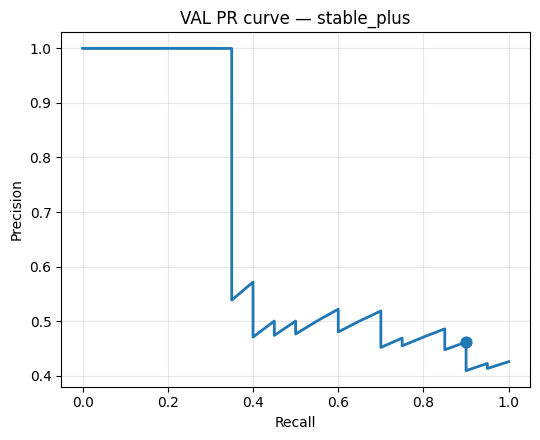

🖼️ PR guardada en: /content/drive/MyDrive/CognitivaAI/ft_effb3_stable_colab_plus/graphs_from_metrics/stable_plus_val_pr_curve.png


In [8]:
# Celda D: Barrido de umbrales y puntos operativos (stable_plus)
import json, os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics as M

OUT_DIR = Path("/content/drive/MyDrive/CognitivaAI/ft_effb3_stable_colab_plus")
OUT_DIR.mkdir(parents=True, exist_ok=True)
GRAPHS = OUT_DIR / "graphs_from_metrics"
GRAPHS.mkdir(parents=True, exist_ok=True)

VAL_CSV  = OUT_DIR / "val_patient_preds.csv"
TEST_CSV = OUT_DIR / "test_patient_preds.csv"

assert VAL_CSV.exists() and TEST_CSV.exists(), "Faltan CSV val/test patient en OUT_DIR."

val = pd.read_csv(VAL_CSV)
tst = pd.read_csv(TEST_CSV)
# Normaliza nombres
val = val.rename(columns={"prob": "y_score", "yprob": "y_score", "probability": "y_score"})
tst = tst.rename(columns={"prob": "y_score", "yprob": "y_score", "probability": "y_score"})
if "y_score" not in val.columns:
    if "logits" in val.columns:
        # fallback rápido: logistic
        val["y_score"] = 1/(1+np.exp(-val["logits"].astype(float)))
        tst["y_score"] = 1/(1+np.exp(-tst["logits"].astype(float)))
    else:
        raise RuntimeError("No encuentro y_score ni logits en val/test CSV.")

yv, pv = val["y_true"].astype(int).to_numpy(), val["y_score"].astype(float).to_numpy()
yt, pt = tst["y_true"].astype(int).to_numpy(), tst["y_score"].astype(float).to_numpy()

def metrics_at_thr(y_true, y_prob, thr):
    yp = (y_prob >= thr).astype(int)
    acc = (yp==y_true).mean()
    p   = M.precision_score(y_true, yp, zero_division=0)
    r   = M.recall_score(y_true, yp, zero_division=0)
    auc = M.roc_auc_score(y_true, y_prob) if len(np.unique(y_true))>1 else np.nan
    prauc = M.average_precision_score(y_true, y_prob) if len(np.unique(y_true))>1 else np.nan
    f1  = M.f1_score(y_true, yp, zero_division=0)
    return dict(Acc=acc, P=p, R=r, F1=f1, AUC=auc, PR_AUC=prauc, thr=float(thr), n=int(len(y_true)))

# Barrido fino
ths = np.linspace(0, 1, 1001)
f1s = []
for t in ths:
    f1s.append(M.f1_score(yv, (pv>=t).astype(int), zero_division=0))
thr_f1 = float(ths[int(np.argmax(f1s))])

# Puntos clínicos (recall targets)
def thr_for_recall(y_true, y_prob, target_r):
    # Busca el umbral mínimo que cumple recall >= target_r
    prec, rec, th = M.precision_recall_curve(y_true, y_prob)
    # precision_recall_curve da th para len-1 de rec; construimos pares
    best_thr = 0.0
    for r, t in zip(rec[:-1], th):
        if r >= target_r:
            best_thr = max(best_thr, float(t))
    return best_thr

thr_r90 = thr_for_recall(yv, pv, 0.90)
thr_r95 = thr_for_recall(yv, pv, 0.95)
thr_r100= thr_for_recall(yv, pv, 1.00)

rows = []
for label, thr in [
    ("F1_opt_VAL", thr_f1),
    ("recall90_VAL", thr_r90),
    ("recall95_VAL", thr_r95),
    ("recall100_VAL", thr_r100),
    ("thr0.0", 0.0),
    ("thr0.5", 0.5),
]:
    m_val = metrics_at_thr(yv, pv, thr)
    m_tst = metrics_at_thr(yt, pt, thr)
    rows.append({"setting": label, "split":"VAL",  **m_val})
    rows.append({"setting": label, "split":"TEST", **m_tst})

df_ops = pd.DataFrame(rows)
df_ops.to_csv(OUT_DIR/"operating_points_stable_plus.csv", index=False)
print("✅ Guardado:", OUT_DIR/"operating_points_stable_plus.csv")
display(df_ops)

# Gráfica PR con punto operativo F1
prec, rec, _ = M.precision_recall_curve(yv, pv)
plt.figure(figsize=(5.5,4.5))
plt.plot(rec, prec, lw=2)
# Punto en F1-opt
yp_val = (pv>=thr_f1).astype(int)
p_f1 = M.precision_score(yv, yp_val, zero_division=0)
r_f1 = M.recall_score(yv, yp_val, zero_division=0)
plt.scatter([r_f1],[p_f1], s=60)
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("VAL PR curve — stable_plus")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(GRAPHS/"stable_plus_val_pr_curve.png", dpi=160)
plt.show()
print("🖼️ PR guardada en:", GRAPHS/"stable_plus_val_pr_curve.png")

,pipeline,VAL_AUC,VAL_PRAUC,VAL_Acc,VAL_P,VAL_R,TEST_AUC,TEST_PRAUC,TEST_Acc,TEST_P,TEST_R
0,Pipeline 8 — FT B3,0.52381,0.433333,0.300000,0.300000,1.00,0.585185,0.582197,0.425532,0.425532,1.0
1,Pipeline 10 — FT B3 (stable_plus),0.62963,0.667302,0.553191,0.485714,0.85,0.546296,0.526225,0.574468,0.500000,0.7


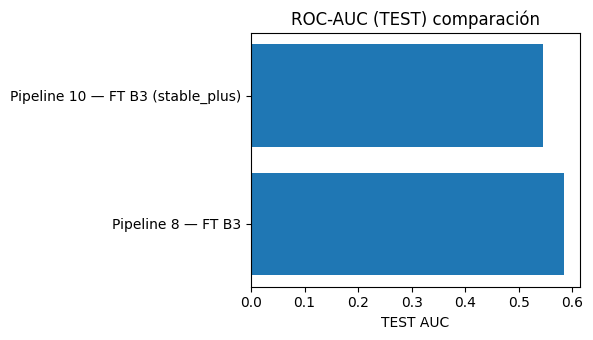

🖼️ Guardado: /content/drive/MyDrive/CognitivaAI/ft_effb3_stable_colab_plus/graphs_from_metrics/stable_plus_vs_ftb3_test_auc.png


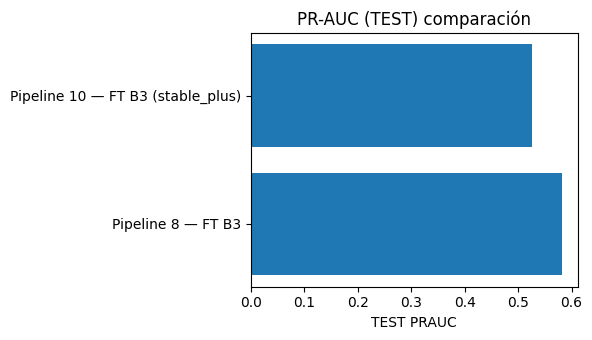

🖼️ Guardado: /content/drive/MyDrive/CognitivaAI/ft_effb3_stable_colab_plus/graphs_from_metrics/stable_plus_vs_ftb3_test_prauc.png


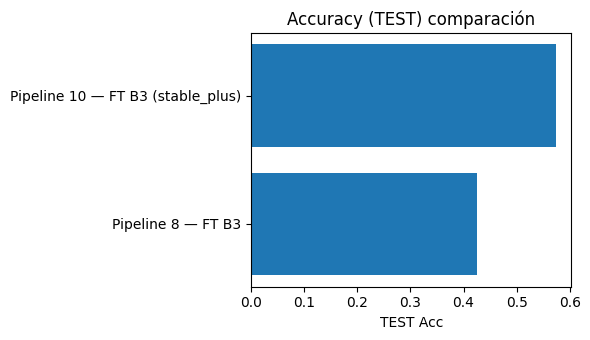

🖼️ Guardado: /content/drive/MyDrive/CognitivaAI/ft_effb3_stable_colab_plus/graphs_from_metrics/stable_plus_vs_ftb3_test_acc.png


In [9]:
# Celda E: Comparativa pipeline 10 vs pipeline 8
import json
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

P8_JSON = Path("/content/drive/MyDrive/CognitivaAI/ft_effb3_colab/ft_effb3_patient_eval.json")
P10_JSON= Path("/content/drive/MyDrive/CognitivaAI/ft_effb3_stable_colab_plus/effb3_stable_patient_eval_calibrated.json")
assert P10_JSON.exists(), f"Falta JSON pipeline 10: {P10_JSON}"

def load_eval(js_path, name):
    if not js_path.exists():
        return None
    with open(js_path, "r", encoding="utf-8") as f:
        d = json.load(f)
    # Estructuras esperadas
    vm = d.get("val_metrics") or d.get("VAL") or {}
    tm = d.get("test_metrics") or d.get("TEST") or {}
    return {
        "pipeline": name,
        "VAL_AUC": vm.get("AUC"),
        "VAL_PRAUC": vm.get("PR-AUC") or vm.get("PR_AUC"),
        "VAL_Acc": vm.get("Acc"),
        "VAL_P": vm.get("P"),
        "VAL_R": vm.get("R"),
        "TEST_AUC": tm.get("AUC"),
        "TEST_PRAUC": tm.get("PR-AUC") or tm.get("PR_AUC"),
        "TEST_Acc": tm.get("Acc"),
        "TEST_P": tm.get("P"),
        "TEST_R": tm.get("R"),
    }

rows = []
p8 = load_eval(P8_JSON, "Pipeline 8 — FT B3")
if p8: rows.append(p8)
p10= load_eval(P10_JSON, "Pipeline 10 — FT B3 (stable_plus)")
rows.append(p10)

comp = pd.DataFrame(rows)
display(comp)

# Barras rápidas de TEST
def barplot(metric_key, title, fname):
    df = comp[["pipeline", metric_key]].dropna()
    if len(df)==0: return
    plt.figure(figsize=(6,3.5))
    plt.barh(df["pipeline"], df[metric_key].astype(float))
    plt.xlabel(metric_key.replace("_"," "))
    plt.title(title)
    plt.tight_layout()
    out = (P10_JSON.parent/"graphs_from_metrics"/fname)
    plt.savefig(out, dpi=160)
    plt.show()
    print("🖼️ Guardado:", out)

barplot("TEST_AUC",   "ROC-AUC (TEST) comparación", "stable_plus_vs_ftb3_test_auc.png")
barplot("TEST_PRAUC", "PR-AUC (TEST) comparación",  "stable_plus_vs_ftb3_test_prauc.png")
barplot("TEST_Acc",   "Accuracy (TEST) comparación","stable_plus_vs_ftb3_test_acc.png")


In [11]:
# Celda F: Ensemble promedio P8+P10 (si hay CSV de ambos)
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn import metrics as M
import json

P8_DIR  = Path("/content/drive/MyDrive/CognitivaAI/ft_effb3_colab")
P10_DIR = Path("/content/drive/MyDrive/CognitivaAI/ft_effb3_stable_colab_plus")

p8_val = P8_DIR/"val_patient_preds.csv"
p8_tst = P8_DIR/"test_patient_preds.csv"
p10_val= P10_DIR/"val_patient_preds.csv"
p10_tst= P10_DIR/"test_patient_preds.csv"

def load_preds(p):
    if not p.exists(): return None
    df = pd.read_csv(p)
    # homogeniza
    df = df.rename(columns={"prob":"yprob","probability":"y_score"})
    if "y_score" not in df.columns and "logits" in df.columns:
        df["y_score"] = 1/(1+np.exp(-df["logits"].astype(float)))
    return df[["patient_id","y_true","y_score"]]

ok = all(x is not None for x in [load_preds(p8_val), load_preds(p8_tst), load_preds(p10_val), load_preds(p10_tst)])
if not ok:
    print("⚠️ Falta alguna de las predicciones (P8 o P10). Me salto el ensemble.")
else:
    v8, t8 = load_preds(p8_val), load_preds(p8_tst)
    v10, t10= load_preds(p10_val), load_preds(p10_tst)
    # join por patient_id (robusto)
    v = v8.merge(v10, on=["patient_id","y_true"], suffixes=("_p8","_p10"))
    t = t8.merge(t10, on=["patient_id","y_true"], suffixes=("_p8","_p10"))
    v["y_score"] = (v["y_score_p8"] + v["y_score_p10"])/2
    t["y_score"] = (t["y_score_p8"] + t["y_score_p10"])/2

    def eval_split(df, thr):
        y = df["y_true"].astype(int).to_numpy()
        p = df["y_score"].astype(float).to_numpy()
        yp = (p>=thr).astype(int)
        return dict(
            AUC = M.roc_auc_score(y,p) if len(np.unique(y))>1 else np.nan,
            PR_AUC = M.average_precision_score(y,p) if len(np.unique(y))>1 else np.nan,
            Acc = (yp==y).mean(),
            P = M.precision_score(y, yp, zero_division=0),
            R = M.recall_score(y, yp, zero_division=0),
            thr=float(thr), n=int(len(y))
        )

    # Umbral F1 óptimo sobre VAL (ensemble)
    ths = np.linspace(0,1,1001)
    f1s = [M.f1_score(v["y_true"], (v["y_score"]>=t).astype(int), zero_division=0) for t in ths]
    thr_f1 = float(ths[int(np.argmax(f1s))])

    metrics_val = eval_split(v, thr_f1)
    metrics_tst = eval_split(t, thr_f1)

    ENSEMBLE_DIR = P10_DIR  # guardamos junto a stable_plus
    v[["patient_id","y_true","y_score"]].to_csv(ENSEMBLE_DIR/"val_patient_preds_ensemble.csv", index=False)
    t[["patient_id","y_true","y_score"]].to_csv(ENSEMBLE_DIR/"test_patient_preds_ensemble.csv", index=False)

    # Añadimos a un JSON resumen
    out_json = ENSEMBLE_DIR/"patient_eval_plus.json"
    j = {}
    if out_json.exists():
        with open(out_json,"r",encoding="utf-8") as f:
            try: j=json.load(f)
            except: j={}
    j["ensemble_avg_p8_p10"] = {"val_metrics":metrics_val, "test_metrics":metrics_tst, "thr_val_f1":thr_f1}
    with open(out_json,"w",encoding="utf-8") as f:
        json.dump(j, f, indent=2)
    print("✅ Ensemble guardado.")
    print("VAL:", metrics_val)
    print("TEST:", metrics_tst)
    print("📁 CSV ensemble en:", ENSEMBLE_DIR)


✅ Ensemble guardado.
VAL: {'AUC': np.float64(0.5238095238095237), 'PR_AUC': np.float64(0.43333333333333335), 'Acc': np.float64(0.7), 'P': 0.5, 'R': 0.6666666666666666, 'thr': 0.46, 'n': 10}
TEST: {'AUC': np.float64(0.5666666666666667), 'PR_AUC': np.float64(0.5711972064331314), 'Acc': np.float64(0.574468085106383), 'P': 0.5, 'R': 0.5, 'thr': 0.46, 'n': 47}
📁 CSV ensemble en: /content/drive/MyDrive/CognitivaAI/ft_effb3_stable_colab_plus


In [12]:
# Celda G: Resumen de artefactos y README de carpeta
from pathlib import Path
import json, time

OUT_DIR = Path("/content/drive/MyDrive/CognitivaAI/ft_effb3_stable_colab_plus")
GRAPHS  = OUT_DIR/"graphs_from_metrics"
EVAL_JSON = OUT_DIR/"effb3_stable_patient_eval_calibrated.json"
OPS_CSV   = OUT_DIR/"operating_points_stable_plus.csv"

print("📦 Artefactos clave en", OUT_DIR)
for p in [
    OUT_DIR/"best_effb3_stable.pth",
    OUT_DIR/"val_patient_preds.csv",
    OUT_DIR/"test_patient_preds.csv",
    EVAL_JSON,
    OPS_CSV,
    GRAPHS/"stable_plus_val_pr_curve.png"
]:
    print(" -", p, "| exists:", p.exists())

# README local
stamp = time.strftime("%Y-%m-%d %H:%M:%S")
blob = [
    f"# Pipeline 10 — stable_plus (snapshot {stamp})",
    "",
    "## Artefactos",
    f"- Checkpoint: {OUT_DIR/'best_effb3_stable.pth'}",
    f"- VAL preds:  {OUT_DIR/'val_patient_preds.csv'}",
    f"- TEST preds: {OUT_DIR/'test_patient_preds.csv'}",
    f"- Eval JSON:  {EVAL_JSON}",
    f"- Operating points: {OPS_CSV}",
    f"- Graficas:   {GRAPHS}",
]
(OUT_DIR/"README_pipeline10.txt").write_text("\n".join(blob), encoding="utf-8")
print("📝 README_pipeline10.txt escrito.")


📦 Artefactos clave en /content/drive/MyDrive/CognitivaAI/ft_effb3_stable_colab_plus
 - /content/drive/MyDrive/CognitivaAI/ft_effb3_stable_colab_plus/best_effb3_stable.pth | exists: True
 - /content/drive/MyDrive/CognitivaAI/ft_effb3_stable_colab_plus/val_patient_preds.csv | exists: True
 - /content/drive/MyDrive/CognitivaAI/ft_effb3_stable_colab_plus/test_patient_preds.csv | exists: True
 - /content/drive/MyDrive/CognitivaAI/ft_effb3_stable_colab_plus/effb3_stable_patient_eval_calibrated.json | exists: True
 - /content/drive/MyDrive/CognitivaAI/ft_effb3_stable_colab_plus/operating_points_stable_plus.csv | exists: True
 - /content/drive/MyDrive/CognitivaAI/ft_effb3_stable_colab_plus/graphs_from_metrics/stable_plus_val_pr_curve.png | exists: True
📝 README_pipeline10.txt escrito.


In [6]:
from pathlib import Path

BASE_DIR  = Path.cwd()   # o cambia a la ruta raíz de tu proyecto
DATA_DIR  = BASE_DIR / "oas1_data"
OUT_DIR   = BASE_DIR / "ft_effb3_stable_colab_plus"
GRAPHS_DIR = OUT_DIR / "graphs_from_metrics"

VAL_MAP  = DATA_DIR / "oas1_val_colab_mapped.csv"
TEST_MAP = DATA_DIR / "oas1_test_colab_mapped.csv"

OUT_DIR.mkdir(parents=True, exist_ok=True)
GRAPHS_DIR.mkdir(parents=True, exist_ok=True)

print("DATA_DIR:", DATA_DIR)
print("OUT_DIR:", OUT_DIR)
print("VAL_MAP:", VAL_MAP.exists(), VAL_MAP)
print("TEST_MAP:", TEST_MAP.exists(), TEST_MAP)


DATA_DIR: /content/oas1_data
OUT_DIR: /content/ft_effb3_stable_colab_plus
VAL_MAP: False /content/oas1_data/oas1_val_colab_mapped.csv
TEST_MAP: False /content/oas1_data/oas1_test_colab_mapped.csv


In [10]:
from pathlib import Path
from google.colab import drive
drive.mount('/content/drive')

# Ajusta esta ruta a donde tengas montado tu proyecto
base = Path("/content/drive/MyDrive/CognitivaAI/ft_effb3_stable_colab_plus")

print("📂 Listando archivos en:", base.resolve())
for p in sorted(base.rglob("*")):
    if p.is_file():
        size = p.stat().st_size/1024
        print(f"{p.relative_to(base)}  ({size:.1f} KB)")


Mounted at /content/drive
📂 Listando archivos en: /content/drive/MyDrive/CognitivaAI/ft_effb3_stable_colab_plus
README_pipeline10.txt  (0.7 KB)
best_effb3_stable.pth  (42339.0 KB)
best_effb3_stable_plus.pth  (42329.2 KB)
effb3_plus_seed41.pth  (42329.2 KB)
effb3_plus_seed42.pth  (42329.2 KB)
effb3_plus_seed43.pth  (42329.2 KB)
effb3_stable_patient_eval.json  (0.5 KB)
effb3_stable_patient_eval_calibrated.json  (0.5 KB)
graphs_from_metrics/confusion_test.png  (18.7 KB)
graphs_from_metrics/confusion_val.png  (18.0 KB)
graphs_from_metrics/plus_bars_auc.png  (16.6 KB)
graphs_from_metrics/plus_bars_prauc.png  (15.4 KB)
graphs_from_metrics/plus_confusion.png  (15.8 KB)
graphs_from_metrics/plus_pr_point.png  (23.4 KB)
graphs_from_metrics/pr_test.png  (43.6 KB)
graphs_from_metrics/pr_val.png  (40.9 KB)
graphs_from_metrics/roc_test.png  (33.6 KB)
graphs_from_metrics/roc_val.png  (33.2 KB)
graphs_from_metrics/stable_plus_pr_test.png  (40.5 KB)
graphs_from_metrics/stable_plus_roc_test.png  (38.8 K

In [11]:
import pandas as pd, numpy as np, json
from pathlib import Path
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, precision_score, recall_score, confusion_matrix
from scipy.optimize import minimize

BASE = Path("/content/drive/MyDrive/CognitivaAI/ft_effb3_stable_colab_plus")

# -------- Helpers --------
def sigmoid(z): return 1/(1+np.exp(-z))
def logit(p, eps=1e-7):
    p = np.clip(p, eps, 1-eps); return np.log(p/(1-p))

def fit_temperature(logits, y_true, init_T=1.0, bounds=(0.05, 10.0)):
    def nll(T):
        p = sigmoid(logits / T); eps=1e-7
        return -np.mean(y_true*np.log(p+eps)+(1-y_true)*np.log(1-p+eps))
    return float(minimize(lambda t: nll(t[0]), x0=[init_T], bounds=[bounds], method="L-BFGS-B").x[0])

def f1_opt_threshold(y_true, y_score):
    thr = np.linspace(0,1,1001)
    f1s = [f1_score(y_true,(y_score>=t).astype(int),zero_division=0) for t in thr]
    return float(thr[int(np.argmax(f1s))])

def youden_threshold(y_true, y_score):
    thr = np.linspace(0,1,1001); best=(-1,0.0)
    for t in thr:
        yhat=(y_score>=t).astype(int)
        tn,fp,fn,tp=confusion_matrix(y_true,yhat).ravel()
        sens=tp/(tp+fn) if (tp+fn)>0 else 0.0
        spec=tn/(tn+fp) if (tn+fp)>0 else 0.0
        j=sens+spec-1
        if j>best[0]: best=(j,float(t))
    return best[1]

def to_patient_df(df):
    if 'logit' not in df.columns:
        if 'y_score' in df.columns:
            df['logit'] = logit(df['y_score'].values)
        elif 'prob' in df.columns:
            df['logit'] = logit(df['prob'].values)
        else:
            raise ValueError("CSV debe tener columna 'logit' o 'y_score'.")
    return df[['patient_id','y_true','logit']]

# -------- Cargar VAL/TEST --------
val_df = pd.read_csv(BASE/'val_patient_preds.csv')
test_df = pd.read_csv(BASE/'test_patient_preds.csv')

val_patient_df  = to_patient_df(val_df)
test_patient_df = to_patient_df(test_df)

# Si no tienes holdout, usamos VAL para calibrar
hold_logits = val_patient_df['logit'].values
hold_y      = val_patient_df['y_true'].values

# -------- Calibración --------
T = fit_temperature(hold_logits, hold_y)
print(f"✅ T (patient-level) = {T:.3f}")

val_p  = sigmoid(val_patient_df['logit'].values / T)
test_p = sigmoid(test_patient_df['logit'].values / T)
vy, ty = val_patient_df['y_true'].values, test_patient_df['y_true'].values

thr_f1 = f1_opt_threshold(vy, val_p)
thr_y  = youden_threshold(vy, val_p)
print(f"🔧 Umbrales → F1: {thr_f1:.3f} | Youden: {thr_y:.3f}")

def metrics(y,p,thr):
    yhat = (p>=thr).astype(int)
    return dict(
        AUC=float(roc_auc_score(y,p)),
        PRAUC=float(average_precision_score(y,p)),
        Acc=float((yhat==y).mean()),
        P=float(precision_score(y,yhat,zero_division=0)),
        R=float(recall_score(y,yhat,zero_division=0)),
        thr=float(thr), n=len(y)
    )

out = {
    "T_patient": T,
    "VAL_F1": metrics(vy, val_p, thr_f1),
    "TEST_F1": metrics(ty, test_p, thr_f1),
    "VAL_Youden": metrics(vy, val_p, thr_y),
    "TEST_Youden": metrics(ty, test_p, thr_y),
}
print(json.dumps(out, indent=2))

with open(BASE/"patient_level_eval_plus.json","w") as f: json.dump(out,f,indent=2)
print("📁 Guardado en patient_level_eval_plus.json")


✅ T (patient-level) = 0.236
🔧 Umbrales → F1: 0.509 | Youden: 0.556
{
  "T_patient": 0.23623499983363191,
  "VAL_F1": {
    "AUC": 0.6296296296296295,
    "PRAUC": 0.6673015670022289,
    "Acc": 0.5531914893617021,
    "P": 0.4857142857142857,
    "R": 0.85,
    "thr": 0.509,
    "n": 47
  },
  "TEST_F1": {
    "AUC": 0.5462962962962963,
    "PRAUC": 0.5262250795839319,
    "Acc": 0.5531914893617021,
    "P": 0.4827586206896552,
    "R": 0.7,
    "thr": 0.509,
    "n": 47
  },
  "VAL_Youden": {
    "AUC": 0.6296296296296295,
    "PRAUC": 0.6673015670022289,
    "Acc": 0.723404255319149,
    "P": 1.0,
    "R": 0.35,
    "thr": 0.556,
    "n": 47
  },
  "TEST_Youden": {
    "AUC": 0.5462962962962963,
    "PRAUC": 0.5262250795839319,
    "Acc": 0.6170212765957447,
    "P": 0.75,
    "R": 0.15,
    "thr": 0.556,
    "n": 47
  }
}
📁 Guardado en patient_level_eval_plus.json


In [12]:
import json, re
import numpy as np, pandas as pd
from pathlib import Path
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, precision_score, recall_score, confusion_matrix
from scipy.optimize import minimize

BASE = Path("/content/drive/MyDrive/CognitivaAI/ft_effb3_stable_colab_plus")

# ----------------- Helpers -----------------
def sigmoid(z): return 1/(1+np.exp(-z))
def logit(p, eps=1e-7):
    p = np.clip(p, eps, 1-eps); return np.log(p/(1-p))

def fit_temperature(logits, y_true, init_T=1.0, bounds=(0.05,10.0)):
    logits = np.asarray(logits, float); y_true = np.asarray(y_true, float)
    def nll(T):
        p = sigmoid(logits / T); eps=1e-7
        return -np.mean(y_true*np.log(p+eps) + (1-y_true)*np.log(1-p+eps))
    return float(minimize(lambda t: nll(t[0]), x0=[init_T], bounds=[bounds], method="L-BFGS-B").x[0])

def f1_opt_threshold(y_true, y_score):
    thr = np.linspace(0,1,1001)
    f1s = [f1_score(y_true, (y_score>=t).astype(int), zero_division=0) for t in thr]
    return float(thr[int(np.argmax(f1s))])

def youden_threshold(y_true, y_score):
    thr = np.linspace(0,1,1001); best=(-1,0.0)
    for t in thr:
        yhat=(y_score>=t).astype(int)
        tn,fp,fn,tp = confusion_matrix(y_true,yhat).ravel()
        sens = tp/(tp+fn) if (tp+fn)>0 else 0.0
        spec = tn/(tn+fp) if (tn+fp)>0 else 0.0
        j = sens + spec - 1
        if j>best[0]: best=(j,float(t))
    return best[1]

def to_patient_df(df):
    cols = {c.lower(): c for c in df.columns}
    pid  = cols.get('patient_id') or cols.get('subject_id') or cols.get('pid') or cols.get('subject')
    ycol = cols.get('y_true') or cols.get('label') or cols.get('target') or cols.get('y')
    if pid is None or ycol is None:
        raise ValueError("Necesito columnas tipo patient_id/subject y y_true/label en el CSV.")

    if 'logit' in df.columns:
        work = df.copy()
    else:
        # buscar probas si no hay logits
        pcol = None
        for c in ['y_score','proba','prob','p']:
            if c in df.columns: pcol = c; break
        if pcol is None:
            # último intento: inferir por regex
            cand = [c for c in df.columns if re.search(r'(score|prob|proba|p(_\d+)?)', c, re.I)]
            if not cand: raise ValueError("No encuentro columnas de 'logit' ni de probabilidad.")
            pcol = cand[0]
        work = df.copy()
        work['logit'] = logit(work[pcol].values)

    g = work.groupby(df.columns[df.columns.str.lower()==pid.lower()][0], as_index=False).agg(
        y_true=(df.columns[df.columns.str.lower()==ycol.lower()][0],'max'),
        logit=('logit','mean')
    )
    return g.rename(columns={pid:'patient_id'})

def read_csv_safe(path: Path):
    if not path.exists(): return None
    try:
        return pd.read_csv(path)
    except Exception:
        return None

def metrics(y,p,thr):
    yhat = (p>=thr).astype(int)
    return dict(
        AUC=float(roc_auc_score(y,p)),
        PRAUC=float(average_precision_score(y,p)),
        Acc=float((yhat==y).mean()),
        P=float(precision_score(y,yhat,zero_division=0)),
        R=float(recall_score(y,yhat,zero_division=0)),
        thr=float(thr),
        n=int(len(y))
    )

# ----------------- Variantes a comparar -----------------
VARIANTS = {
    "base_patient": {
        "val": BASE/"val_patient_preds.csv",
        "test": BASE/"test_patient_preds.csv",
        "level": "patient"
    },
    "plus_patient": {
        "val": BASE/"val_patient_preds_plus.csv",
        "test": BASE/"test_patient_preds_plus.csv",
        "level": "patient"
    },
    "plus_slice": {
        "val": BASE/"val_slice_preds_plus.csv",
        "test": BASE/"test_slice_preds_plus.csv",
        "level": "slice"  # se agregará a paciente
    }
}

results_rows = []
all_json = {}

for name, cfg in VARIANTS.items():
    val_raw  = read_csv_safe(cfg["val"])
    test_raw = read_csv_safe(cfg["test"])
    if val_raw is None or test_raw is None:
        print(f"⚠️ Omito {name}: no existen ficheros {cfg['val'].name} / {cfg['test'].name}")
        continue

    # a paciente si es slice-level
    if cfg["level"] == "slice":
        val_pat  = to_patient_df(val_raw)
        test_pat = to_patient_df(test_raw)
    else:
        val_pat  = to_patient_df(val_raw)
        test_pat = to_patient_df(test_raw)

    # Calibración T en VAL (si quisieras y hay holdout_patient, podrías usarlo aquí)
    T = fit_temperature(val_pat['logit'].values, val_pat['y_true'].values, init_T=1.0)
    val_p  = sigmoid(val_pat['logit'].values / T)
    test_p = sigmoid(test_pat['logit'].values / T)
    vy, ty = val_pat['y_true'].values.astype(int), test_pat['y_true'].values.astype(int)

    # Umbrales por VAL
    thr_f1 = f1_opt_threshold(vy, val_p)
    thr_y  = youden_threshold(vy, val_p)

    out = {
        "variant": name,
        "T": float(T),
        "VAL_F1": metrics(vy, val_p, thr_f1),
        "TEST_F1": metrics(ty, test_p, thr_f1),
        "VAL_Youden": metrics(vy, val_p, thr_y),
        "TEST_Youden": metrics(ty, test_p, thr_y),
    }
    all_json[name] = out

    # filas resumen para tabla
    results_rows += [
        dict(variant=name, split="VAL",  scheme="F1",     **out["VAL_F1"]),
        dict(variant=name, split="TEST", scheme="F1",     **out["TEST_F1"]),
        dict(variant=name, split="VAL",  scheme="YOUDEN", **out["VAL_Youden"]),
        dict(variant=name, split="TEST", scheme="YOUDEN", **out["TEST_Youden"]),
    ]

# ----------------- Salida -----------------
if results_rows:
    df_cmp = pd.DataFrame(results_rows)
    display(df_cmp.sort_values(["variant","split","scheme"]).reset_index(drop=True))
    out_csv = BASE/"comparison_patient_level_eval.csv"
    df_cmp.to_csv(out_csv, index=False)
    with open(BASE/"comparison_patient_level_eval.json","w") as f:
        json.dump(all_json, f, indent=2)
    print("📁 Guardado:", out_csv)
else:
    print("❌ No se pudo evaluar ninguna variante. Revisa que existan los CSV en", BASE)


,variant,split,scheme,AUC,PRAUC,Acc,P,R,thr,n
0,base_patient,TEST,F1,0.546296,0.526225,0.553191,0.482759,0.70,0.509,47
1,base_patient,TEST,YOUDEN,0.546296,0.526225,0.617021,0.750000,0.15,0.556,47
2,base_patient,VAL,F1,0.629630,0.667302,0.553191,0.485714,0.85,0.509,47
3,base_patient,VAL,YOUDEN,0.629630,0.667302,0.723404,1.000000,0.35,0.556,47
4,plus_patient,TEST,F1,0.738889,0.698776,0.659574,0.666667,0.40,0.458,47
5,plus_patient,TEST,YOUDEN,0.738889,0.698776,0.659574,0.666667,0.40,0.458,47
6,plus_patient,VAL,F1,0.907407,0.920085,0.872340,0.937500,0.75,0.458,47
7,plus_patient,VAL,YOUDEN,0.907407,0.920085,0.872340,0.937500,0.75,0.458,47
8,plus_slice,TEST,F1,0.750000,0.734029,0.638298,0.560000,0.70,0.295,47
9,plus_slice,TEST,YOUDEN,0.750000,0.734029,0.638298,0.560000,0.70,0.295,47


📁 Guardado: /content/drive/MyDrive/CognitivaAI/ft_effb3_stable_colab_plus/comparison_patient_level_eval.csv


In [13]:
# === Recalcular predicciones con TTA reducido (orig + hflip) y guardar CSV ===
import os, re, json, math
from pathlib import Path
import numpy as np
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T

# -------------------- Config --------------------
BASE = Path("/content/drive/MyDrive/CognitivaAI/ft_effb3_stable_colab_plus")
CKPT = BASE / "best_effb3_stable_plus.pth"   # puedes cambiar a otro .pth si quieres
IMG_SIZE = 300
BATCH_SIZE = 64
NUM_WORKERS = 2
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

VAL_PNG = BASE / "val_png_preds.csv"   # deben tener columnas: png_path, patient_id, y_true
TEST_PNG = BASE / "test_png_preds.csv"

assert VAL_PNG.exists() and TEST_PNG.exists(), "No encuentro val_png_preds.csv o test_png_preds.csv"

# -------------------- Dataset --------------------
class PNGDataset(Dataset):
    def __init__(self, df, transform):
        self.df = df.reset_index(drop=True)
        self.t = transform

    def __len__(self): return len(self.df)

    def __getitem__(self, i):
        row = self.df.iloc[i]
        path = row["png_path"]
        # soportar rutas relativas a la carpeta base
        p = Path(path)
        if not p.exists():
            # intenta resolver relativo a BASE
            p = (BASE / Path(path)).resolve()
        img = Image.open(p).convert("RGB")
        img = self.t(img)
        y = torch.tensor(row["y_true"], dtype=torch.float32)
        pid = row["patient_id"]
        return img, y, pid, str(p)

# -------------------- Transforms --------------------
base_tf = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    # Normalización ImageNet (EffNet preentrenada)
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

hflip_tf = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.RandomHorizontalFlip(p=1.0),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# -------------------- Modelo --------------------
def build_model(num_classes=1):
    model = None
    err = None
    try:
        import timm
        model = timm.create_model('tf_efficientnet_b3_ns', pretrained=False, num_classes=num_classes)
        print("✅ Cargado backbone timm: tf_efficientnet_b3_ns")
        return model
    except Exception as e:
        err = e
        print("⚠️ timm no disponible o modelo no creado, intento con torchvision:", e)
    try:
        from torchvision.models import efficientnet_b3, EfficientNet_B3_Weights
        model = efficientnet_b3(weights=None)
        # reemplazar classifier para binario
        in_features = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(in_features, num_classes)
        print("✅ Cargado backbone torchvision: efficientnet_b3")
        return model
    except Exception as e2:
        print("❌ No pude crear EfficientNet-B3 con timm ni torchvision.")
        raise e2

def load_checkpoint_forgiving(model, ckpt_path: Path):
    sd = torch.load(ckpt_path, map_location="cpu")
    # algunos checkpoints guardan como {'model': state_dict, ...}
    if isinstance(sd, dict) and "state_dict" in sd:
        sd = sd["state_dict"]
    missing, unexpected = model.load_state_dict(sd, strict=False)
    print(f"Checkpoint cargado con strict=False. Missing: {len(missing)}, Unexpected: {len(unexpected)}")

# -------------------- Inferencia (TTA reducido) --------------------
@torch.inference_mode()
def infer_split(df_png: pd.DataFrame, model: nn.Module):
    ds_orig = PNGDataset(df_png, base_tf)
    ds_flip = PNGDataset(df_png, hflip_tf)
    dl_orig = DataLoader(ds_orig, batch_size=BATCH_SIZE, shuffle=False,
                         num_workers=NUM_WORKERS, pin_memory=True)
    dl_flip = DataLoader(ds_flip, batch_size=BATCH_SIZE, shuffle=False,
                         num_workers=NUM_WORKERS, pin_memory=True)

    model.eval().to(DEVICE)

    all_logits = []
    all_paths = []
    all_pids = []
    all_y = []

    # Pass 1: original
    idx = 0
    for (x, y, pid, paths) in dl_orig:
        x = x.to(DEVICE, non_blocking=True)
        out = model(x)
        logits = out.squeeze(-1).float().detach().cpu().numpy()
        all_logits.append(logits)
        if idx == 0:
            all_paths.extend(paths)
            all_pids.extend(pid)
            all_y.extend(y.numpy().tolist())
        idx += 1

    # Pass 2: hflip
    logits_flip = []
    for (x, _, _, _) in dl_flip:
        x = x.to(DEVICE, non_blocking=True)
        out = model(x)
        logits = out.squeeze(-1).float().detach().cpu().numpy()
        logits_flip.append(logits)

    logits_orig = np.concatenate(all_logits, axis=0)
    logits_flip = np.concatenate(logits_flip, axis=0)

    # Promedio TTA reducido (orig + hflip)
    logits_tta = (logits_orig + logits_flip) / 2.0

    out_df = pd.DataFrame({
        "png_path": all_paths,
        "patient_id": all_pids,
        "y_true": np.array(all_y, dtype=int),
        "logit": logits_tta.astype(float),
    })
    return out_df

# -------------------- Ejecutar --------------------
print("📦 Cargando CSV de rutas...")
val_png_df = pd.read_csv(VAL_PNG)
test_png_df = pd.read_csv(TEST_PNG)

print("🧠 Construyendo modelo...")
model = build_model(num_classes=1)
print("📥 Cargando checkpoint:", CKPT.name)
load_checkpoint_forgiving(model, CKPT)

print("🔮 Inferencia VAL (TTA reducido: orig + hflip)...")
val_slice_tta = infer_split(val_png_df, model)
print("🔮 Inferencia TEST (TTA reducido: orig + hflip)...")
test_slice_tta = infer_split(test_png_df, model)

# Guardar slice-level
val_slice_path = BASE / "val_slice_preds_plus_TTAreduced.csv"
test_slice_path = BASE / "test_slice_preds_plus_TTAreduced.csv"
val_slice_tta.to_csv(val_slice_path, index=False)
test_slice_tta.to_csv(test_slice_path, index=False)
print("💾 Guardado slice-level:")
print("  -", val_slice_path.name)
print("  -", test_slice_path.name)

# Agregar a paciente (media de logits)
def to_patient(df):
    g = df.groupby("patient_id", as_index=False).agg(
        y_true=('y_true','max'),
        logit=('logit','mean')
    )
    return g

val_pat_tta = to_patient(val_slice_tta)
test_pat_tta = to_patient(test_slice_tta)

val_pat_path = BASE / "val_patient_preds_plus_TTAreduced.csv"
test_pat_path = BASE / "test_patient_preds_plus_TTAreduced.csv"
val_pat_tta.to_csv(val_pat_path, index=False)
test_pat_tta.to_csv(test_pat_path, index=False)
print("💾 Guardado patient-level:")
print("  -", val_pat_path.name)
print("  -", test_pat_path.name)

print("✅ Listo. Ahora puedes pasar esta variante como 'plus_slice_TTAreduced' a tu celda de comparación.")


📦 Cargando CSV de rutas...
🧠 Construyendo modelo...


/usr/local/lib/python3.12/dist-packages/timm/models/_factory.py:138: UserWarning: Mapping deprecated model name tf_efficientnet_b3_ns to current tf_efficientnet_b3.ns_jft_in1k.
  model = create_fn(


✅ Cargado backbone timm: tf_efficientnet_b3_ns
📥 Cargando checkpoint: best_effb3_stable_plus.pth
Checkpoint cargado con strict=False. Missing: 0, Unexpected: 0
🔮 Inferencia VAL (TTA reducido: orig + hflip)...


KeyError: Caught KeyError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/pandas/core/indexes/base.py", line 3805, in get_loc
    return self._engine.get_loc(casted_key)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "index.pyx", line 167, in pandas._libs.index.IndexEngine.get_loc
  File "index.pyx", line 196, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 7081, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 7089, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 'png_path'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/_utils/worker.py", line 349, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
           ^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/_utils/fetch.py", line 52, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
            ~~~~~~~~~~~~^^^^^
  File "/tmp/ipython-input-4221064182.py", line 36, in __getitem__
    path = row["png_path"]
           ~~~^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pandas/core/series.py", line 1121, in __getitem__
    return self._get_value(key)
           ^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pandas/core/series.py", line 1237, in _get_value
    loc = self.index.get_loc(label)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pandas/core/indexes/base.py", line 3812, in get_loc
    raise KeyError(key) from err
KeyError: 'png_path'


In [14]:
from pathlib import Path
import pandas as pd

BASE = Path("/content/drive/MyDrive/CognitivaAI/ft_effb3_stable_colab_plus")
files = [
    "val_patient_preds.csv",
    "test_patient_preds.csv",
    "val_patient_preds_plus.csv",
    "test_patient_preds_plus.csv",
    "val_slice_preds_plus.csv",
    "test_slice_preds_plus.csv",
]

for fn in files:
    p = BASE/fn
    if p.exists():
        df = pd.read_csv(p, nrows=3)
        print("✅", fn, "-> cols:", list(df.columns))
    else:
        print("—", fn, "(no existe)")


✅ val_patient_preds.csv -> cols: ['patient_id', 'y_true', 'logit', 'y_score']
✅ test_patient_preds.csv -> cols: ['patient_id', 'y_true', 'logit', 'y_score']
✅ val_patient_preds_plus.csv -> cols: ['patient_id', 'y_true', 'y_score']
✅ test_patient_preds_plus.csv -> cols: ['patient_id', 'y_true', 'y_score']
✅ val_slice_preds_plus.csv -> cols: ['patient_id', 'y_true', 'y_score']
✅ test_slice_preds_plus.csv -> cols: ['patient_id', 'y_true', 'y_score']


In [15]:
import json, re
import numpy as np, pandas as pd
from pathlib import Path
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, precision_score, recall_score, confusion_matrix
from scipy.optimize import minimize

BASE = Path("/content/drive/MyDrive/CognitivaAI/ft_effb3_stable_colab_plus")

# -------- Helpers --------
def sigmoid(z): return 1/(1+np.exp(-z))
def logit_from_proba(p, eps=1e-7):
    p = np.clip(p, eps, 1-eps); return np.log(p/(1-p))

def fit_temperature(logits, y_true, init_T=1.0, bounds=(0.05,10.0)):
    logits = np.asarray(logits, float); y_true = np.asarray(y_true, float)
    def nll(T):
        p = sigmoid(logits / T); eps=1e-7
        return -np.mean(y_true*np.log(p+eps)+(1-y_true)*np.log(1-p+eps))
    return float(minimize(lambda t: nll(t[0]), x0=[init_T], bounds=[bounds], method="L-BFGS-B").x[0])

def f1_opt_threshold(y_true, y_score):
    thr = np.linspace(0,1,1001)
    f1s = [f1_score(y_true,(y_score>=t).astype(int), zero_division=0) for t in thr]
    return float(thr[int(np.argmax(f1s))])

def youden_threshold(y_true, y_score):
    thr = np.linspace(0,1,1001); best=(-1,0.0)
    for t in thr:
        yhat=(y_score>=t).astype(int)
        tn,fp,fn,tp = confusion_matrix(y_true,yhat).ravel()
        sens = tp/(tp+fn) if (tp+fn)>0 else 0.0
        spec = tn/(tn+fp) if (tn+fp)>0 else 0.0
        j = sens + spec - 1
        if j>best[0]: best=(j,float(t))
    return best[1]

def standardize_logits_df(df):
    """Devuelve DF con columnas ['patient_id','y_true','logit'].
       Acepta 'logit' o 'logits'; si no hay, intenta a partir de proba."""
    cols = {c.lower(): c for c in df.columns}
    pid  = cols.get('patient_id') or cols.get('subject_id') or cols.get('pid') or cols.get('subject')
    ycol = cols.get('y_true') or cols.get('label') or cols.get('target') or cols.get('y')
    if pid is None or ycol is None:
        raise ValueError(f"Necesito patient_id/subject y y_true/label. Tengo: {list(df.columns)}")

    work = df.copy()
    if 'logit' in cols:
        lg = cols['logit']
        out = work.rename(columns={pid:'patient_id', ycol:'y_true', lg:'logit'})[['patient_id','y_true','logit']]
        return out
    if 'logits' in cols:
        lg = cols['logits']
        work = work.rename(columns={pid:'patient_id', ycol:'y_true', lg:'logit'})
        return work[['patient_id','y_true','logit']]

    # si no hay logits, pruebo con probabilidades
    for pcol_name in ['y_score','proba','prob','p']:
        if pcol_name in cols:
            pcol = cols[pcol_name]
            work['logit'] = logit_from_proba(work[pcol].values)
            return work.rename(columns={pid:'patient_id', ycol:'y_true'})[['patient_id','y_true','logit']]

    # último intento: detectar por regex
    cand = [c for c in df.columns if re.search(r'(score|prob|proba|p(_\d+)?)', c, re.I)]
    if cand:
        work['logit'] = logit_from_proba(work[cand[0]].values)
        return work.rename(columns={pid:'patient_id', ycol:'y_true'})[['patient_id','y_true','logit']]

    raise ValueError("No encuentro 'logit/logits' ni probas para derivar logits.")

def to_patient_df(df):
    """Si ya viene a nivel paciente no agregará nada; si trae múltiples filas por paciente, hace mean de logits y max de y_true."""
    df_std = standardize_logits_df(df)
    if df_std.groupby('patient_id').size().max() == 1:
        return df_std[['patient_id','y_true','logit']]
    g = df_std.groupby('patient_id', as_index=False).agg(
        y_true=('y_true','max'),
        logit=('logit','mean')
    )
    return g

def read_csv_safe(p: Path):
    if not p.exists(): return None
    try:
        return pd.read_csv(p)
    except Exception:
        return None

def metrics(y,p,thr):
    yhat = (p>=thr).astype(int)
    return dict(
        AUC=float(roc_auc_score(y,p)),
        PRAUC=float(average_precision_score(y,p)),
        Acc=float((yhat==y).mean()),
        P=float(precision_score(y,yhat,zero_division=0)),
        R=float(recall_score(y,yhat,zero_division=0)),
        thr=float(thr),
        n=int(len(y))
    )

# -------- Variantes --------
VARIANTS = {
    "base_patient": {
        "val": BASE/"val_patient_preds.csv",
        "test": BASE/"test_patient_preds.csv",
        "level": "patient"
    },
    "plus_patient": {
        "val": BASE/"val_patient_preds_plus.csv",
        "test": BASE/"test_patient_preds_plus.csv",
        "level": "patient"
    },
    "plus_slice": {
        "val": BASE/"val_slice_preds_plus.csv",
        "test": BASE/"test_slice_preds_plus.csv",
        "level": "slice"  # agregamos a paciente
    },
    # Si más tarde generas TTA reducido, descomenta:
    # "plus_slice_TTAreduced": {
    #     "val": BASE/"val_slice_preds_plus_TTAreduced.csv",
    #     "test": BASE/"test_slice_preds_plus_TTAreduced.csv",
    #     "level": "slice"
    # }
}

rows = []
all_json = {}

for name, cfg in VARIANTS.items():
    val_raw  = read_csv_safe(cfg["val"])
    test_raw = read_csv_safe(cfg["test"])
    if val_raw is None or test_raw is None:
        print(f"⚠️ Omito {name}: faltan {cfg['val'].name} / {cfg['test'].name}")
        continue

    if cfg["level"] == "slice":
        val_pat  = to_patient_df(val_raw)   # hará mean(logits) por patient
        test_pat = to_patient_df(test_raw)
    else:
        val_pat  = to_patient_df(val_raw)
        test_pat = to_patient_df(test_raw)

    # Calibra T en VAL patient-level
    T = fit_temperature(val_pat['logit'].values, val_pat['y_true'].values, init_T=1.0)
    val_p  = sigmoid(val_pat['logit'].values / T)
    test_p = sigmoid(test_pat['logit'].values / T)
    vy, ty = val_pat['y_true'].values.astype(int), test_pat['y_true'].values.astype(int)

    thr_f1 = f1_opt_threshold(vy, val_p)
    thr_y  = youden_threshold(vy, val_p)

    out = {
        "variant": name,
        "T": float(T),
        "VAL_F1": metrics(vy, val_p, thr_f1),
        "TEST_F1": metrics(ty, test_p, thr_f1),
        "VAL_Youden": metrics(vy, val_p, thr_y),
        "TEST_Youden": metrics(ty, test_p, thr_y),
    }
    all_json[name] = out

    rows += [
        dict(variant=name, split="VAL",  scheme="F1",     **out["VAL_F1"]),
        dict(variant=name, split="TEST", scheme="F1",     **out["TEST_F1"]),
        dict(variant=name, split="VAL",  scheme="YOUDEN", **out["VAL_Youden"]),
        dict(variant=name, split="TEST", scheme="YOUDEN", **out["TEST_Youden"]),
    ]

if rows:
    df_cmp = pd.DataFrame(rows).sort_values(["variant","split","scheme"]).reset_index(drop=True)
    display(df_cmp)
    out_csv = BASE/"comparison_patient_level_eval.csv"
    df_cmp.to_csv(out_csv, index=False)
    with open(BASE/"comparison_patient_level_eval.json","w") as f:
        json.dump(all_json, f, indent=2)
    print("📁 Guardado:", out_csv)
else:
    print("❌ No se pudo evaluar ninguna variante (revisa rutas/archivos).")


,variant,split,scheme,AUC,PRAUC,Acc,P,R,thr,n
0,base_patient,TEST,F1,0.546296,0.526225,0.553191,0.482759,0.70,0.509,47
1,base_patient,TEST,YOUDEN,0.546296,0.526225,0.617021,0.750000,0.15,0.556,47
2,base_patient,VAL,F1,0.629630,0.667302,0.553191,0.485714,0.85,0.509,47
3,base_patient,VAL,YOUDEN,0.629630,0.667302,0.723404,1.000000,0.35,0.556,47
4,plus_patient,TEST,F1,0.738889,0.698776,0.659574,0.666667,0.40,0.458,47
5,plus_patient,TEST,YOUDEN,0.738889,0.698776,0.659574,0.666667,0.40,0.458,47
6,plus_patient,VAL,F1,0.907407,0.920085,0.872340,0.937500,0.75,0.458,47
7,plus_patient,VAL,YOUDEN,0.907407,0.920085,0.872340,0.937500,0.75,0.458,47
8,plus_slice,TEST,F1,0.750000,0.734029,0.638298,0.560000,0.70,0.295,47
9,plus_slice,TEST,YOUDEN,0.750000,0.734029,0.638298,0.560000,0.70,0.295,47


📁 Guardado: /content/drive/MyDrive/CognitivaAI/ft_effb3_stable_colab_plus/comparison_patient_level_eval.csv


In [16]:
# === Agregar variantes de pooling por paciente (sin re-inferir) y añadir a la comparación ===
import json, numpy as np, pandas as pd
from pathlib import Path
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, precision_score, recall_score, confusion_matrix
from scipy.optimize import minimize

BASE = Path("/content/drive/MyDrive/CognitivaAI/ft_effb3_stable_colab_plus")

VAL_SLICE = BASE/"val_slice_preds_plus.csv"   # cols: patient_id, y_true, y_score
TEST_SLICE = BASE/"test_slice_preds_plus.csv"

assert VAL_SLICE.exists() and TEST_SLICE.exists(), "Faltan val_slice_preds_plus.csv / test_slice_preds_plus.csv"

# ---------- helpers ----------
def sigmoid(z): return 1/(1+np.exp(-z))
def logit_from_proba(p, eps=1e-7):
    p = np.clip(p, eps, 1-eps); return np.log(p/(1-p))

def fit_temperature(logits, y_true, init_T=1.0, bounds=(0.05,10.0)):
    logits = np.asarray(logits, float); y_true = np.asarray(y_true, float)
    def nll(T):
        p = sigmoid(logits / T); eps=1e-7
        return -np.mean(y_true*np.log(p+eps)+(1-y_true)*np.log(1-p+eps))
    return float(minimize(lambda t: nll(t[0]), x0=[init_T], bounds=[bounds], method="L-BFGS-B").x[0])

def f1_opt_threshold(y_true, y_score):
    thr = np.linspace(0,1,1001)
    f1s = [f1_score(y_true, (y_score>=t).astype(int), zero_division=0) for t in thr]
    return float(thr[int(np.argmax(f1s))])

def youden_threshold(y_true, y_score):
    thr = np.linspace(0,1,1001); best=(-1,0.0)
    for t in thr:
        yhat=(y_score>=t).astype(int)
        tn,fp,fn,tp=confusion_matrix(y_true,yhat).ravel()
        sens=tp/(tp+fn) if (tp+fn)>0 else 0.0
        spec=tn/(tn+fp) if (tn+fp)>0 else 0.0
        j=sens+spec-1
        if j>best[0]: best=(j,float(t))
    return best[1]

def metrics(y,p,thr):
    yhat = (p>=thr).astype(int)
    return dict(
        AUC=float(roc_auc_score(y,p)),
        PRAUC=float(average_precision_score(y,p)),
        Acc=float((yhat==y).mean()),
        P=float(precision_score(y,yhat,zero_division=0)),
        R=float(recall_score(y,yhat,zero_division=0)),
        thr=float(thr), n=int(len(y))
    )

# ---------- cargar slice-level y pasar a logits ----------
val_slice = pd.read_csv(VAL_SLICE)
test_slice = pd.read_csv(TEST_SLICE)

assert all(c in val_slice.columns for c in ["patient_id","y_true","y_score"])
assert all(c in test_slice.columns for c in ["patient_id","y_true","y_score"])

val_slice = val_slice.copy()
test_slice = test_slice.copy()
val_slice["logit"]  = logit_from_proba(val_slice["y_score"].values)
test_slice["logit"] = logit_from_proba(test_slice["y_score"].values)

# ---------- agregadores por paciente ----------
def agg_patient(df, how="mean", topk=None, trim_alpha=0.2):
    g = []
    for pid, sub in df.groupby("patient_id"):
        y = int(sub["y_true"].max())
        logits = sub["logit"].values
        if how == "mean":
            L = float(np.mean(logits))
        elif how == "median":
            L = float(np.median(logits))
        elif how == "topk":
            k = min(topk or 3, len(logits))
            L = float(np.mean(np.sort(logits)[-k:]))
        elif how == "trimmed":
            if len(logits) < 5:
                L = float(np.mean(logits))
            else:
                a = int(np.floor(trim_alpha*len(logits)))
                L = float(np.mean(np.sort(logits)[a:len(logits)-a]))
        else:
            raise ValueError("how inválido")
        g.append((pid, y, L))
    return pd.DataFrame(g, columns=["patient_id","y_true","logit"])

VARIANTS = {
    "plus_slice_MEAN":    lambda df: agg_patient(df, how="mean"),
    "plus_slice_MEDIAN":  lambda df: agg_patient(df, how="median"),
    "plus_slice_TOP3":    lambda df: agg_patient(df, how="topk", topk=3),
    "plus_slice_TOP7":    lambda df: agg_patient(df, how="topk", topk=7),
    "plus_slice_TRIMMED": lambda df: agg_patient(df, how="trimmed", trim_alpha=0.2),
}

rows = []
all_json = {}

for name, fn in VARIANTS.items():
    val_pat = fn(val_slice)
    test_pat = fn(test_slice)

    # calibrar T en VAL
    T = fit_temperature(val_pat["logit"].values, val_pat["y_true"].values, init_T=1.0)
    val_p  = sigmoid(val_pat["logit"].values / T)
    test_p = sigmoid(test_pat["logit"].values / T)
    vy, ty = val_pat["y_true"].values.astype(int), test_pat["y_true"].values.astype(int)

    thr_f1 = f1_opt_threshold(vy, val_p)
    thr_y  = youden_threshold(vy, val_p)

    out = {
        "variant": name,
        "T": float(T),
        "VAL_F1": metrics(vy, val_p, thr_f1),
        "TEST_F1": metrics(ty, test_p, thr_f1),
        "VAL_Youden": metrics(vy, val_p, thr_y),
        "TEST_Youden": metrics(ty, test_p, thr_y),
    }
    all_json[name] = out

    rows += [
        dict(variant=name, split="VAL",  scheme="F1",     **out["VAL_F1"]),
        dict(variant=name, split="TEST", scheme="F1",     **out["TEST_F1"]),
        dict(variant=name, split="VAL",  scheme="YOUDEN", **out["VAL_Youden"]),
        dict(variant=name, split="TEST", scheme="YOUDEN", **out["TEST_Youden"]),
    ]

# ---------- fusionar con tu comparación previa ----------
cmp_path = BASE/"comparison_patient_level_eval.csv"
if cmp_path.exists():
    df_prev = pd.read_csv(cmp_path)
    df_new  = pd.DataFrame(rows)
    df_out  = pd.concat([df_prev, df_new], ignore_index=True)
else:
    df_out  = pd.DataFrame(rows)

df_out.to_csv(cmp_path, index=False)
with open(BASE/"comparison_patient_level_eval_extended.json","w") as f:
    json.dump(all_json, f, indent=2)

display(df_out.sort_values(["variant","split","scheme"]).reset_index(drop=True))
print("📁 Actualizado:", cmp_path)


,variant,split,scheme,AUC,PRAUC,Acc,P,R,thr,n
0,base_patient,TEST,F1,0.546296,0.526225,0.553191,0.482759,0.70,0.509,47
1,base_patient,TEST,YOUDEN,0.546296,0.526225,0.617021,0.750000,0.15,0.556,47
2,base_patient,VAL,F1,0.629630,0.667302,0.553191,0.485714,0.85,0.509,47
3,base_patient,VAL,YOUDEN,0.629630,0.667302,0.723404,1.000000,0.35,0.556,47
4,plus_patient,TEST,F1,0.738889,0.698776,0.659574,0.666667,0.40,0.458,47
5,plus_patient,TEST,YOUDEN,0.738889,0.698776,0.659574,0.666667,0.40,0.458,47
6,plus_patient,VAL,F1,0.907407,0.920085,0.872340,0.937500,0.75,0.458,47
7,plus_patient,VAL,YOUDEN,0.907407,0.920085,0.872340,0.937500,0.75,0.458,47
8,plus_slice,TEST,F1,0.750000,0.734029,0.638298,0.560000,0.70,0.295,47
9,plus_slice,TEST,YOUDEN,0.750000,0.734029,0.638298,0.560000,0.70,0.295,47


📁 Actualizado: /content/drive/MyDrive/CognitivaAI/ft_effb3_stable_colab_plus/comparison_patient_level_eval.csv


In [17]:
# === plus_slice_TRIMMED con objetivo de recall (p.ej. 0.80) y volcado a comparación ===
import numpy as np, pandas as pd, json
from pathlib import Path
from sklearn.metrics import roc_auc_score, average_precision_score, precision_score, recall_score

BASE = Path("/content/drive/MyDrive/CognitivaAI/ft_effb3_stable_colab_plus")
VAL_SLICE  = BASE/"val_slice_preds_plus.csv"   # cols: patient_id, y_true, y_score
TEST_SLICE = BASE/"test_slice_preds_plus.csv"
CMP_CSV    = BASE/"comparison_patient_level_eval.csv"

target_recall = 0.80   # <-- cambia aquí si quieres probar 0.85/0.90

def sigmoid(z): return 1/(1+np.exp(-z))
def logit_from_proba(p, eps=1e-7):
    p = np.clip(p, eps, 1-eps); return np.log(p/(1-p))
def fit_temperature(logits, y_true, init_T=1.0, bounds=(0.05,10.0)):
    from scipy.optimize import minimize
    logits = np.asarray(logits, float); y_true = np.asarray(y_true, float)
    def nll(T):
        p = sigmoid(logits / T); eps=1e-7
        return -np.mean(y_true*np.log(p+eps)+(1-y_true)*np.log(1-p+eps))
    return float(minimize(lambda t: nll(t[0]), x0=[init_T], bounds=[bounds], method="L-BFGS-B").x[0])

def agg_trimmed_logits(df, alpha=0.2):
    # convierte a logits y agrega TRIMMED-mean por paciente
    df = df.copy()
    df["logit"] = logit_from_proba(df["y_score"].values)
    rows = []
    for pid, g in df.groupby("patient_id"):
        y = int(g["y_true"].max())
        L = g["logit"].values
        if len(L) < 5:
            m = float(np.mean(L))
        else:
            a = int(np.floor(alpha*len(L)))
            Ls = np.sort(L)
            m = float(np.mean(Ls[a:len(L)-a]))
        rows.append((pid, y, m))
    return pd.DataFrame(rows, columns=["patient_id","y_true","logit"])

# 1) Cargar slice-level y construir TRIMMED a nivel paciente
val_slice  = pd.read_csv(VAL_SLICE)
test_slice = pd.read_csv(TEST_SLICE)
val_pat  = agg_trimmed_logits(val_slice, alpha=0.2)
test_pat = agg_trimmed_logits(test_slice, alpha=0.2)

# 2) Calibrar T en VAL (patient-level)
T = fit_temperature(val_pat["logit"].values, val_pat["y_true"].values, init_T=1.0)
val_p  = sigmoid(val_pat["logit"].values  / T)
test_p = sigmoid(test_pat["logit"].values / T)
vy, ty = val_pat["y_true"].values.astype(int), test_pat["y_true"].values.astype(int)

# 3) Buscar el umbral mínimo en VAL que cumpla recall >= target_recall
ths = np.linspace(0, 1, 2001)
chosen_thr = None
for thr in ths:
    yhat = (val_p >= thr).astype(int)
    r = recall_score(vy, yhat, zero_division=0)
    if r >= target_recall:
        chosen_thr = float(thr)
        break
if chosen_thr is None:
    chosen_thr = 0.0  # si no se alcanza, toma el más bajo posible (max recall)

def pack_metrics(y, p, thr):
    yhat = (p >= thr).astype(int)
    return dict(
        AUC=float(roc_auc_score(y, p)),
        PRAUC=float(average_precision_score(y, p)),
        Acc=float((yhat == y).mean()),
        P=float(precision_score(y, yhat, zero_division=0)),
        R=float(recall_score(y, yhat, zero_division=0)),
        thr=float(thr),
        n=int(len(y))
    )

VAL_REC = pack_metrics(vy, val_p, chosen_thr)
TEST_REC= pack_metrics(ty, test_p, chosen_thr)

print(f"✅ T(patient, TRIMMED) = {T:.3f}")
print(f"🎯 target_recall={target_recall:.2f} → thr_VAL={chosen_thr:.3f}")
print("VAL@REC:", json.dumps(VAL_REC, indent=2))
print("TEST@REC:", json.dumps(TEST_REC, indent=2))

# 4) Volcar a comparación
row_val  = dict(variant="plus_slice_TRIMMED", split="VAL",  scheme=f"REC{target_recall:.2f}",  **VAL_REC)
row_test = dict(variant="plus_slice_TRIMMED", split="TEST", scheme=f"REC{target_recall:.2f}",  **TEST_REC)

if CMP_CSV.exists():
    df_cmp = pd.read_csv(CMP_CSV)
    df_cmp = pd.concat([df_cmp, pd.DataFrame([row_val, row_test])], ignore_index=True)
else:
    df_cmp = pd.DataFrame([row_val, row_test])

df_cmp.to_csv(CMP_CSV, index=False)
print("📁 Actualizado:", CMP_CSV)


✅ T(patient, TRIMMED) = 0.559
🎯 target_recall=0.80 → thr_VAL=0.000
VAL@REC: {
  "AUC": 0.8944444444444444,
  "PRAUC": 0.9045334837841779,
  "Acc": 0.425531914893617,
  "P": 0.425531914893617,
  "R": 1.0,
  "thr": 0.0,
  "n": 47
}
TEST@REC: {
  "AUC": 0.7444444444444444,
  "PRAUC": 0.7461098185895183,
  "Acc": 0.425531914893617,
  "P": 0.425531914893617,
  "R": 1.0,
  "thr": 0.0,
  "n": 47
}
📁 Actualizado: /content/drive/MyDrive/CognitivaAI/ft_effb3_stable_colab_plus/comparison_patient_level_eval.csv


In [18]:
# === ROC & PR para plus_slice_TRIMMED (VAL/TEST) con umbrales marcados ===
import numpy as np, pandas as pd, json, os
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    precision_recall_curve, roc_curve,
    precision_score, recall_score, f1_score, confusion_matrix
)
from scipy.optimize import minimize

BASE = Path("/content/drive/MyDrive/CognitivaAI/ft_effb3_stable_colab_plus")
VAL_SLICE  = BASE/"val_slice_preds_plus.csv"    # cols: patient_id, y_true, y_score
TEST_SLICE = BASE/"test_slice_preds_plus.csv"
FIG_DIR    = BASE/"graphs_from_metrics"
FIG_DIR.mkdir(parents=True, exist_ok=True)

def sigmoid(z): return 1/(1+np.exp(-z))
def logit_from_proba(p, eps=1e-7):
    p = np.clip(p, eps, 1-eps); return np.log(p/(1-p))

def fit_temperature(logits, y_true, init_T=1.0, bounds=(0.05,10.0)):
    logits = np.asarray(logits, float); y_true = np.asarray(y_true, float)
    def nll(T):
        p = sigmoid(logits / T); eps=1e-7
        return -np.mean(y_true*np.log(p+eps)+(1-y_true)*np.log(1-p+eps))
    return float(minimize(lambda t: nll(t[0]), x0=[init_T], bounds=[bounds], method="L-BFGS-B").x[0])

def agg_trimmed_logits(df, alpha=0.2):
    """Media recortada al 20% (por defecto) de logits por paciente."""
    df = df.copy()
    df["logit"] = logit_from_proba(df["y_score"].values)
    rows = []
    for pid, g in df.groupby("patient_id"):
        y = int(g["y_true"].max())
        L = np.sort(g["logit"].values)
        if len(L) < 5:
            m = float(np.mean(L))
        else:
            a = int(np.floor(alpha*len(L)))
            m = float(np.mean(L[a:len(L)-a]))
        rows.append((pid, y, m))
    return pd.DataFrame(rows, columns=["patient_id","y_true","logit"])

def f1_opt_threshold(y_true, y_score):
    ths = np.linspace(0,1,2001)
    f1s = [f1_score(y_true, (y_score>=t).astype(int), zero_division=0) for t in ths]
    return float(ths[int(np.argmax(f1s))])

def youden_threshold(y_true, y_score):
    ths = np.linspace(0,1,2001)
    best, best_thr = -1.0, 0.5
    for t in ths:
        yhat = (y_score>=t).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, yhat).ravel()
        sens = tp/(tp+fn) if (tp+fn)>0 else 0.0
        spec = tn/(tn+fp) if (tn+fp)>0 else 0.0
        j = sens + spec - 1
        if j > best:
            best, best_thr = j, float(t)
    return best_thr

def pack_metrics(y, p, thr):
    yhat = (p>=thr).astype(int)
    return dict(
        AUC=float(roc_auc_score(y, p)),
        PRAUC=float(average_precision_score(y, p)),
        Acc=float((yhat==y).mean()),
        P=float(precision_score(y, yhat, zero_division=0)),
        R=float(recall_score(y, yhat, zero_division=0)),
        thr=float(thr),
        n=int(len(y))
    )

# 1) Cargar slice-level y construir TRIMMED a nivel paciente
val_slice  = pd.read_csv(VAL_SLICE)
test_slice = pd.read_csv(TEST_SLICE)
val_pat  = agg_trimmed_logits(val_slice, alpha=0.2)
test_pat = agg_trimmed_logits(test_slice, alpha=0.2)

# 2) Calibrar T en VAL y obtener probabilidades calibradas
T = fit_temperature(val_pat["logit"].values, val_pat["y_true"].values, init_T=1.0)
val_p  = sigmoid(val_pat["logit"].values  / T)
test_p = sigmoid(test_pat["logit"].values / T)
vy, ty = val_pat["y_true"].values.astype(int), test_pat["y_true"].values.astype(int)

# 3) Umbrales en VAL
thr_f1_val    = f1_opt_threshold(vy, val_p)
thr_youden    = youden_threshold(vy, val_p)
thr_recall1   = 0.0  # para recall objetivo ~1.0

# 4) Curvas y CSVs (VAL)
prec_v, rec_v, thr_pr_v = precision_recall_curve(vy, val_p)
fpr_v, tpr_v, thr_roc_v = roc_curve(vy, val_p)
pd.DataFrame({"recall":rec_v, "precision":prec_v}).to_csv(FIG_DIR/"trimmed_val_pr_points.csv", index=False)
pd.DataFrame({"fpr":fpr_v, "tpr":tpr_v}).to_csv(FIG_DIR/"trimmed_val_roc_points.csv", index=False)

# 5) Curvas y CSVs (TEST)
prec_t, rec_t, thr_pr_t = precision_recall_curve(ty, test_p)
fpr_t, tpr_t, thr_roc_t = roc_curve(ty, test_p)
pd.DataFrame({"recall":rec_t, "precision":prec_t}).to_csv(FIG_DIR/"trimmed_test_pr_points.csv", index=False)
pd.DataFrame({"fpr":fpr_t, "tpr":tpr_t}).to_csv(FIG_DIR/"trimmed_test_roc_points.csv", index=False)

# 6) Métricas para tabla (opcional)
m_val_f1   = pack_metrics(vy, val_p, thr_f1_val)
m_test_f1  = pack_metrics(ty, test_p, thr_f1_val)
m_val_y    = pack_metrics(vy, val_p, thr_youden)
m_test_y   = pack_metrics(ty, test_p, thr_youden)
m_val_rec1 = pack_metrics(vy, val_p, thr_recall1)
m_test_rec1= pack_metrics(ty, test_p, thr_recall1)

print("T =", round(T,3))
print("VAL  F1-opt:", m_val_f1)
print("TEST F1-opt:", m_test_f1)
print("VAL  Youden:", m_val_y)
print("TEST Youden:", m_test_y)
print("VAL  Rec=1:", m_val_rec1)
print("TEST Rec=1:", m_test_rec1)

# 7) Función para marcar puntos en curvas
def prob_to_point_PR(y, p, thr):
    # Encuentra (recall, precision) en el umbral dado
    yhat = (p>=thr).astype(int)
    r = recall_score(y, yhat, zero_division=0)
    pr= precision_score(y, yhat, zero_division=0)
    return r, pr

def prob_to_point_ROC(y, p, thr):
    yhat = (p>=thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y, yhat).ravel()
    tpr = tp/(tp+fn) if (tp+fn)>0 else 0.0
    fpr = fp/(fp+tn) if (fp+tn)>0 else 0.0
    return fpr, tpr

# 8) Graficar y guardar
def plot_and_save_PR(rec, prec, y, p, thrs, labels, title, out_path):
    plt.figure(figsize=(6,5))
    plt.plot(rec, prec, linewidth=2)
    for thr, lab in zip(thrs, labels):
        r, pr = prob_to_point_PR(y, p, thr)
        plt.scatter([r], [pr], s=60, label=f"{lab} (thr={thr:.3f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(out_path, dpi=200)
    plt.close()
    print("💾 Guardado:", out_path.name)

def plot_and_save_ROC(fpr, tpr, y, p, thrs, labels, title, out_path):
    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, linewidth=2)
    plt.plot([0,1],[0,1],'--',alpha=0.5)
    for thr, lab in zip(thrs, labels):
        x, y_ = prob_to_point_ROC(y, p, thr)
        plt.scatter([x], [y_], s=60, label=f"{lab} (thr={thr:.3f})")
    plt.xlabel("FPR")
    plt.ylabel("TPR (Recall)")
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(out_path, dpi=200)
    plt.close()
    print("💾 Guardado:", out_path.name)

# VAL
plot_and_save_PR(rec_v, prec_v, vy, val_p,
                 [thr_f1_val, thr_youden, thr_recall1],
                 ["F1-opt", "Youden", "Recall=1.0"],
                 "PR Curve — VAL (TRIMMED)", FIG_DIR/"trimmed_val_pr_curve.png")
plot_and_save_ROC(fpr_v, tpr_v, vy, val_p,
                  [thr_f1_val, thr_youden, thr_recall1],
                  ["F1-opt", "Youden", "Recall=1.0"],
                  "ROC Curve — VAL (TRIMMED)", FIG_DIR/"trimmed_val_roc_curve.png")

# TEST (señalamos los mismos umbrales aprendidos en VAL)
plot_and_save_PR(rec_t, prec_t, ty, test_p,
                 [thr_f1_val, thr_youden, thr_recall1],
                 ["F1-opt (VAL)", "Youden (VAL)", "Recall=1.0"],
                 "PR Curve — TEST (TRIMMED)", FIG_DIR/"trimmed_test_pr_curve.png")
plot_and_save_ROC(fpr_t, tpr_t, ty, test_p,
                  [thr_f1_val, thr_youden, thr_recall1],
                  ["F1-opt (VAL)", "Youden (VAL)", "Recall=1.0"],
                  "ROC Curve — TEST (TRIMMED)", FIG_DIR/"trimmed_test_roc_curve.png")


T = 0.559
VAL  F1-opt: {'AUC': 0.8944444444444444, 'PRAUC': 0.9045334837841779, 'Acc': 0.8297872340425532, 'P': 0.7307692307692307, 'R': 0.95, 'thr': 0.2915, 'n': 47}
TEST F1-opt: {'AUC': 0.7444444444444444, 'PRAUC': 0.7461098185895183, 'Acc': 0.6382978723404256, 'P': 0.5555555555555556, 'R': 0.75, 'thr': 0.2915, 'n': 47}
VAL  Youden: {'AUC': 0.8944444444444444, 'PRAUC': 0.9045334837841779, 'Acc': 0.8297872340425532, 'P': 0.7307692307692307, 'R': 0.95, 'thr': 0.2915, 'n': 47}
TEST Youden: {'AUC': 0.7444444444444444, 'PRAUC': 0.7461098185895183, 'Acc': 0.6382978723404256, 'P': 0.5555555555555556, 'R': 0.75, 'thr': 0.2915, 'n': 47}
VAL  Rec=1: {'AUC': 0.8944444444444444, 'PRAUC': 0.9045334837841779, 'Acc': 0.425531914893617, 'P': 0.425531914893617, 'R': 1.0, 'thr': 0.0, 'n': 47}
TEST Rec=1: {'AUC': 0.7444444444444444, 'PRAUC': 0.7461098185895183, 'Acc': 0.425531914893617, 'P': 0.425531914893617, 'R': 1.0, 'thr': 0.0, 'n': 47}
💾 Guardado: trimmed_val_pr_curve.png
💾 Guardado: trimmed_val_r

In [20]:
# === Mini-ensemble MEAN + TRIMMED + TOP7 (versión robusta) ===
import itertools, json
import numpy as np, pandas as pd
from pathlib import Path
from sklearn.metrics import (
    average_precision_score, roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix
)
from scipy.optimize import minimize

BASE = Path("/content/drive/MyDrive/CognitivaAI/ft_effb3_stable_colab_plus")
VAL_SLICE  = BASE/"val_slice_preds_plus.csv"   # cols: patient_id, y_true, y_score
TEST_SLICE = BASE/"test_slice_preds_plus.csv"
CMP_CSV    = BASE/"comparison_patient_level_eval.csv"

assert VAL_SLICE.exists() and TEST_SLICE.exists(), "Faltan val_slice_preds_plus.csv / test_slice_preds_plus.csv"

def sigmoid(z): return 1/(1+np.exp(-z))
def logit_from_proba(p, eps=1e-7):
    p = np.clip(p, eps, 1-eps); return np.log(p/(1-p))

def fit_temperature(logits, y_true, init_T=1.0, bounds=(0.05, 10.0)):
    logits = np.asarray(logits, float); y_true = np.asarray(y_true, float)
    def nll(T):
        p = sigmoid(logits / T); eps=1e-7
        return -np.mean(y_true*np.log(p+eps)+(1-y_true)*np.log(1-p+eps))
    return float(minimize(lambda t: nll(t[0]), x0=[init_T], bounds=[bounds], method="L-BFGS-B").x[0])

def f1_opt_threshold(y_true, y_score):
    ths = np.linspace(0,1,1001)
    f1s = [f1_score(y_true,(y_score>=t).astype(int), zero_division=0) for t in ths]
    return float(ths[int(np.argmax(f1s))])

def youden_threshold(y_true, y_score):
    ths = np.linspace(0,1,1001); best, best_thr = -1.0, 0.5
    for t in ths:
        yhat=(y_score>=t).astype(int)
        tn,fp,fn,tp = confusion_matrix(y_true,yhat).ravel()
        sens = tp/(tp+fn) if (tp+fn)>0 else 0.0
        spec = tn/(tn+fp) if (tn+fp)>0 else 0.0
        j = sens + spec - 1
        if j>best: best, best_thr = j, float(t)
    return best_thr

def metrics(y,p,thr):
    yhat=(p>=thr).astype(int)
    return dict(
        AUC=float(roc_auc_score(y,p)),
        PRAUC=float(average_precision_score(y,p)),
        Acc=float((yhat==y).mean()),
        P=float(precision_score(y,yhat,zero_division=0)),
        R=float(recall_score(y,yhat,zero_division=0)),
        thr=float(thr), n=int(len(y))
    )

# ---------- cargar slice-level y pasar a logits ----------
val_slice  = pd.read_csv(VAL_SLICE).copy()
test_slice = pd.read_csv(TEST_SLICE).copy()
for df in (val_slice, test_slice):
    assert set(["patient_id","y_true","y_score"]).issubset(df.columns)
    df["logit"] = logit_from_proba(df["y_score"].values)

# ---------- agregadores por paciente ----------
def agg_mean(df):
    return df.groupby("patient_id", as_index=False).agg(y_true=("y_true","max"), logit=("logit","mean"))

def agg_trimmed(df, alpha=0.2):
    rows=[]
    for pid,g in df.groupby("patient_id"):
        y = int(g["y_true"].max()); L = np.sort(g["logit"].values)
        if len(L)<5: m=float(np.mean(L))
        else:
            a=int(np.floor(alpha*len(L))); m=float(np.mean(L[a:len(L)-a]))
        rows.append((pid,y,m))
    return pd.DataFrame(rows, columns=["patient_id","y_true","logit"])

def agg_topk(df, k=7):
    rows=[]
    for pid,g in df.groupby("patient_id"):
        y=int(g["y_true"].max()); L=np.sort(g["logit"].values)
        k=min(k,len(L)); m=float(np.mean(L[-k:]))
        rows.append((pid,y,m))
    return pd.DataFrame(rows, columns=["patient_id","y_true","logit"])

# VAL
val_mean  = agg_mean(val_slice).rename(columns={"logit":"logit_mean"})
val_trim  = agg_trimmed(val_slice, alpha=0.2).rename(columns={"logit":"logit_trim"})
val_top7  = agg_topk(val_slice, k=7).rename(columns={"logit":"logit_top7"})
val_all = val_mean.merge(val_trim, on=["patient_id","y_true"]).merge(val_top7, on=["patient_id","y_true"])

# TEST
test_mean = agg_mean(test_slice).rename(columns={"logit":"logit_mean"})
test_trim = agg_trimmed(test_slice, alpha=0.2).rename(columns={"logit":"logit_trim"})
test_top7 = agg_topk(test_slice, k=7).rename(columns={"logit":"logit_top7"})
test_all = test_mean.merge(test_trim, on=["patient_id","y_true"]).merge(test_top7, on=["patient_id","y_true"])

# ---------- búsqueda de pesos (max PR-AUC en VAL) ----------
grid = np.linspace(0,1,11)  # paso 0.1
vy = val_all["y_true"].values.astype(int)
best_pr, best_w = -1.0, (1/3,1/3,1/3)

for w_mean in grid:
    for w_trim in grid:
        w_top7 = 1.0 - w_mean - w_trim
        if w_top7 < -1e-9:
            continue
        w = np.array([w_mean, w_trim, max(0.0, w_top7)], dtype=float)
        w = w / w.sum()
        v_logit = w[0]*val_all["logit_mean"].values + w[1]*val_all["logit_trim"].values + w[2]*val_all["logit_top7"].values
        pr = average_precision_score(vy, sigmoid(v_logit))
        if pr > best_pr:
            best_pr, best_w = pr, tuple(w)

print(f"🏆 Pesos óptimos (VAL PR-AUC): mean={best_w[0]:.2f}, trimmed={best_w[1]:.2f}, top7={best_w[2]:.2f} | PR-AUC={best_pr:.3f}")

# ---------- construir logits ensemble ----------
val_logit_ens  = best_w[0]*val_all["logit_mean"].values + best_w[1]*val_all["logit_trim"].values + best_w[2]*val_all["logit_top7"].values
test_logit_ens = best_w[0]*test_all["logit_mean"].values + best_w[1]*test_all["logit_trim"].values + best_w[2]*test_all["logit_top7"].values

# ---------- calibración T en VAL y umbrales ----------
T_ens = fit_temperature(val_logit_ens, vy, init_T=1.0)
val_p  = sigmoid(val_logit_ens / T_ens)
test_p = sigmoid(test_logit_ens / T_ens)
ty     = test_all["y_true"].values.astype(int)

thr_f1 = f1_opt_threshold(vy, val_p)
thr_y  = youden_threshold(vy, val_p)

def pack(y,p,thr):
    yhat=(p>=thr).astype(int)
    return dict(
        AUC=float(roc_auc_score(y,p)),
        PRAUC=float(average_precision_score(y,p)),
        Acc=float((yhat==y).mean()),
        P=float(precision_score(y,yhat,zero_division=0)),
        R=float(recall_score(y,yhat,zero_division=0)),
        thr=float(thr), n=int(len(y))
    )

out = {
    "variant": "ensemble_mean+trimmed+top7",
    "weights": {"mean": float(best_w[0]), "trimmed": float(best_w[1]), "top7": float(best_w[2])},
    "T": float(T_ens),
    "VAL_F1": pack(vy, val_p, thr_f1),
    "TEST_F1": pack(ty, test_p, thr_f1),
    "VAL_Youden": pack(vy, val_p, thr_y),
    "TEST_Youden": pack(ty, test_p, thr_y),
}
print(json.dumps(out, indent=2))

# ---------- volcamos a comparación ----------
rows = [
    dict(variant="ensemble_mean+trimmed+top7", split="VAL",  scheme="F1",     **out["VAL_F1"]),
    dict(variant="ensemble_mean+trimmed+top7", split="TEST", scheme="F1",     **out["TEST_F1"]),
    dict(variant="ensemble_mean+trimmed+top7", split="VAL",  scheme="YOUDEN", **out["VAL_Youden"]),
    dict(variant="ensemble_mean+trimmed+top7", split="TEST", scheme="YOUDEN", **out["TEST_Youden"]),
]
cmp_df = pd.read_csv(CMP_CSV) if CMP_CSV.exists() else pd.DataFrame(columns=rows[0].keys())
cmp_df = pd.concat([cmp_df, pd.DataFrame(rows)], ignore_index=True)
cmp_df.to_csv(CMP_CSV, index=False)
print("📁 Actualizado:", CMP_CSV)



🏆 Pesos óptimos (VAL PR-AUC): mean=0.30, trimmed=0.10, top7=0.60 | PR-AUC=0.925
{
  "variant": "ensemble_mean+trimmed+top7",
  "weights": {
    "mean": 0.30000000000000004,
    "trimmed": 0.1,
    "top7": 0.6
  },
  "T": 0.2813661623340397,
  "VAL_F1": {
    "AUC": 0.912962962962963,
    "PRAUC": 0.9245842013956371,
    "Acc": 0.8723404255319149,
    "P": 0.7916666666666666,
    "R": 0.95,
    "thr": 0.259,
    "n": 47
  },
  "TEST_F1": {
    "AUC": 0.7537037037037037,
    "PRAUC": 0.7368147439935366,
    "Acc": 0.6808510638297872,
    "P": 0.6086956521739131,
    "R": 0.7,
    "thr": 0.259,
    "n": 47
  },
  "VAL_Youden": {
    "AUC": 0.912962962962963,
    "PRAUC": 0.9245842013956371,
    "Acc": 0.8723404255319149,
    "P": 0.7916666666666666,
    "R": 0.95,
    "thr": 0.259,
    "n": 47
  },
  "TEST_Youden": {
    "AUC": 0.7537037037037037,
    "PRAUC": 0.7368147439935366,
    "Acc": 0.6808510638297872,
    "P": 0.6086956521739131,
    "R": 0.7,
    "thr": 0.259,
    "n": 47
  }
}


In [21]:
# === Ensemble (mean+trimmed+top7) con objetivo recall >= 0.90 ===
import numpy as np, pandas as pd, json
from pathlib import Path
from sklearn.metrics import roc_auc_score, average_precision_score, precision_score, recall_score
from scipy.optimize import minimize

BASE = Path("/content/drive/MyDrive/CognitivaAI/ft_effb3_stable_colab_plus")
VAL_SLICE  = BASE/"val_slice_preds_plus.csv"
TEST_SLICE = BASE/"test_slice_preds_plus.csv"
CMP_CSV    = BASE/"comparison_patient_level_eval.csv"

# Pesos óptimos del ensemble (encontrados antes)
W = {"mean":0.30, "trimmed":0.10, "top7":0.60}

def sigmoid(z): return 1/(1+np.exp(-z))
def logit_from_proba(p, eps=1e-7):
    p = np.clip(p, eps, 1-eps); return np.log(p/(1-p))

def fit_temperature(logits, y_true, init_T=1.0, bounds=(0.05,10.0)):
    logits = np.asarray(logits, float); y_true = np.asarray(y_true, float)
    def nll(T):
        p = sigmoid(logits / T); eps=1e-7
        return -np.mean(y_true*np.log(p+eps)+(1-y_true)*np.log(1-p+eps))
    return float(minimize(lambda t: nll(t[0]), x0=[init_T], bounds=[bounds], method="L-BFGS-B").x[0])

def agg_mean(df):
    return df.groupby("patient_id", as_index=False).agg(y_true=("y_true","max"), logit=("logit","mean"))

def agg_trimmed(df, alpha=0.2):
    rows=[]
    for pid,g in df.groupby("patient_id"):
        y=int(g["y_true"].max()); L=np.sort(g["logit"].values)
        if len(L)<5: m=float(np.mean(L))
        else:
            a=int(np.floor(alpha*len(L))); m=float(np.mean(L[a:len(L)-a]))
        rows.append((pid,y,m))
    return pd.DataFrame(rows, columns=["patient_id","y_true","logit"])

def agg_topk(df, k=7):
    rows=[]
    for pid,g in df.groupby("patient_id"):
        y=int(g["y_true"].max()); L=np.sort(g["logit"].values)
        k=min(k,len(L)); m=float(np.mean(L[-k:]))
        rows.append((pid,y,m))
    return pd.DataFrame(rows, columns=["patient_id","y_true","logit"])

# 1) Cargar slice-level y convertir a logits
val_slice  = pd.read_csv(VAL_SLICE).copy()
test_slice = pd.read_csv(TEST_SLICE).copy()
for df in (val_slice, test_slice):
    df["logit"] = logit_from_proba(df["y_score"].values)

# 2) Construir agregaciones
val_mean, test_mean   = agg_mean(val_slice), agg_mean(test_slice)
val_trim, test_trim   = agg_trimmed(val_slice), agg_trimmed(test_slice)
val_top7, test_top7   = agg_topk(val_slice), agg_topk(test_slice)

# 3) Alinear y crear logits ensemble
val_all = val_mean.merge(val_trim, on=["patient_id","y_true"], suffixes=("_mean","_trim"))
val_all = val_all.merge(val_top7.rename(columns={"logit":"logit_top7"}), on=["patient_id","y_true"])
test_all = test_mean.merge(test_trim, on=["patient_id","y_true"], suffixes=("_mean","_trim"))
test_all = test_all.merge(test_top7.rename(columns={"logit":"logit_top7"}), on=["patient_id","y_true"])

val_logit_ens  = W["mean"]*val_all["logit_mean"].values + W["trimmed"]*val_all["logit_trim"].values + W["top7"]*val_all["logit_top7"].values
test_logit_ens = W["mean"]*test_all["logit_mean"].values + W["trimmed"]*test_all["logit_trim"].values + W["top7"]*test_all["logit_top7"].values

vy, ty = val_all["y_true"].values.astype(int), test_all["y_true"].values.astype(int)

# 4) Calibrar T
T = fit_temperature(val_logit_ens, vy, init_T=1.0)
val_p, test_p = sigmoid(val_logit_ens/T), sigmoid(test_logit_ens/T)

# 5) Buscar threshold mínimo en VAL con recall >= 0.90
ths = np.linspace(0,1,2001)
chosen_thr = None
for thr in ths:
    r = recall_score(vy, (val_p>=thr).astype(int), zero_division=0)
    if r >= 0.90:
        chosen_thr = float(thr)
        break
if chosen_thr is None:
    chosen_thr = 0.0

def pack_metrics(y,p,thr):
    yhat = (p>=thr).astype(int)
    return dict(
        AUC=float(roc_auc_score(y,p)),
        PRAUC=float(average_precision_score(y,p)),
        Acc=float((yhat==y).mean()),
        P=float(precision_score(y,yhat,zero_division=0)),
        R=float(recall_score(y,yhat,zero_division=0)),
        thr=float(thr), n=len(y)
    )

VAL_REC = pack_metrics(vy, val_p, chosen_thr)
TEST_REC= pack_metrics(ty, test_p, chosen_thr)

print(f"✅ Ensemble recall-target=0.90 → T={T:.3f}, thr={chosen_thr:.3f}")
print("VAL:", json.dumps(VAL_REC, indent=2))
print("TEST:", json.dumps(TEST_REC, indent=2))

# 6) Guardar en comparación
rows = [
    dict(variant="ensemble_mean+trimmed+top7", split="VAL",  scheme="REC0.90", **VAL_REC),
    dict(variant="ensemble_mean+trimmed+top7", split="TEST", scheme="REC0.90", **TEST_REC),
]
df_cmp = pd.read_csv(CMP_CSV) if CMP_CSV.exists() else pd.DataFrame(columns=rows[0].keys())
df_cmp = pd.concat([df_cmp, pd.DataFrame(rows)], ignore_index=True)
df_cmp.to_csv(CMP_CSV, index=False)
print("📁 Actualizado:", CMP_CSV)


✅ Ensemble recall-target=0.90 → T=0.281, thr=0.000
VAL: {
  "AUC": 0.912962962962963,
  "PRAUC": 0.9245842013956371,
  "Acc": 0.425531914893617,
  "P": 0.425531914893617,
  "R": 1.0,
  "thr": 0.0,
  "n": 47
}
TEST: {
  "AUC": 0.7537037037037037,
  "PRAUC": 0.7368147439935366,
  "Acc": 0.425531914893617,
  "P": 0.425531914893617,
  "R": 1.0,
  "thr": 0.0,
  "n": 47
}
📁 Actualizado: /content/drive/MyDrive/CognitivaAI/ft_effb3_stable_colab_plus/comparison_patient_level_eval.csv


In [23]:
# === PR-Curves combinadas: TRIMMED vs Ensemble (VAL y TEST) ===
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import precision_recall_curve, average_precision_score
from scipy.optimize import minimize

BASE = Path("/content/drive/MyDrive/CognitivaAI/ft_effb3_stable_colab_plus")
VAL_SLICE  = BASE/"val_slice_preds_plus.csv"
TEST_SLICE = BASE/"test_slice_preds_plus.csv"
FIG_DIR    = BASE/"graphs_from_metrics"
FIG_DIR.mkdir(parents=True, exist_ok=True)

def sigmoid(z): return 1/(1+np.exp(-z))
def logit_from_proba(p, eps=1e-7):
    p = np.clip(p, eps, 1-eps); return np.log(p/(1-p))
def fit_temperature(logits, y_true, init_T=1.0, bounds=(0.05,10.0)):
    def nll(T):
        p = sigmoid(logits/T); eps=1e-7
        return -np.mean(y_true*np.log(p+eps)+(1-y_true)*np.log(1-p+eps))
    return float(minimize(lambda t: nll(t[0]), x0=[init_T], bounds=[bounds]).x[0])

def agg_trimmed(df, alpha=0.2):
    rows=[]
    for pid,g in df.groupby("patient_id"):
        y=int(g["y_true"].max()); L=np.sort(g["logit"].values)
        if len(L)<5: m=np.mean(L)
        else:
            a=int(np.floor(alpha*len(L))); m=np.mean(L[a:len(L)-a])
        rows.append((pid,y,m))
    return pd.DataFrame(rows, columns=["patient_id","y_true","logit"])

def agg_mean(df): return df.groupby("patient_id",as_index=False).agg(y_true=("y_true","max"),logit=("logit","mean"))
def agg_topk(df,k=7):
    rows=[]
    for pid,g in df.groupby("patient_id"):
        y=int(g["y_true"].max()); L=np.sort(g["logit"].values)
        k=min(k,len(L)); m=np.mean(L[-k:])
        rows.append((pid,y,m))
    return pd.DataFrame(rows, columns=["patient_id","y_true","logit"])

# cargar slice-level
val_slice, test_slice = pd.read_csv(VAL_SLICE), pd.read_csv(TEST_SLICE)
for df in (val_slice, test_slice):
    df["logit"] = logit_from_proba(df["y_score"].values)

# --- TRIMMED ---
val_trim, test_trim = agg_trimmed(val_slice), agg_trimmed(test_slice)
T_trim = fit_temperature(val_trim["logit"].values, val_trim["y_true"].values)
val_p_trim, test_p_trim = sigmoid(val_trim["logit"].values/T_trim), sigmoid(test_trim["logit"].values/T_trim)

# --- ENSEMBLE ---
# pesos hallados: mean=0.30, trimmed=0.10, top7=0.60
val_mean, test_mean = agg_mean(val_slice), agg_mean(test_slice)
val_top7, test_top7 = agg_topk(val_slice), agg_topk(test_slice)
val_all = val_mean.merge(val_trim, on=["patient_id","y_true"], suffixes=("_mean","_trim"))
val_all = val_all.merge(val_top7.rename(columns={"logit":"logit_top7"}), on=["patient_id","y_true"])
test_all = test_mean.merge(test_trim, on=["patient_id","y_true"], suffixes=("_mean","_trim"))
test_all = test_all.merge(test_top7.rename(columns={"logit":"logit_top7"}), on=["patient_id","y_true"])

val_logit_ens = 0.30*val_all["logit_mean"].values + 0.10*val_all["logit_trim"].values + 0.60*val_all["logit_top7"].values
test_logit_ens = 0.30*test_all["logit_mean"].values + 0.10*test_all["logit_trim"].values + 0.60*test_all["logit_top7"].values
T_ens = fit_temperature(val_logit_ens, val_all["y_true"].values)
val_p_ens, test_p_ens = sigmoid(val_logit_ens/T_ens), sigmoid(test_logit_ens/T_ens)

# --- PR Curves ---
prec_v_trim, rec_v_trim, _ = precision_recall_curve(val_trim["y_true"], val_p_trim)
prec_v_ens, rec_v_ens, _  = precision_recall_curve(val_all["y_true"], val_p_ens)
prec_t_trim, rec_t_trim, _= precision_recall_curve(test_trim["y_true"], test_p_trim)
prec_t_ens, rec_t_ens, _  = precision_recall_curve(test_all["y_true"], test_p_ens)

# --- Plot VAL ---
plt.figure(figsize=(6,5))
plt.plot(rec_v_trim, prec_v_trim, label=f"TRIMMED (AP={average_precision_score(val_trim['y_true'],val_p_trim):.3f})")
plt.plot(rec_v_ens,  prec_v_ens,  label=f"ENSEMBLE (AP={average_precision_score(val_all['y_true'],val_p_ens):.3f})")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("PR Curve — VAL")
plt.legend(); plt.grid(True, alpha=0.3)
plt.tight_layout(); plt.savefig(FIG_DIR/"pr_curve_trimmed_vs_ensemble_val.png", dpi=200); plt.close()
print("💾 Guardado: pr_curve_trimmed_vs_ensemble_val.png")

# --- Plot TEST ---
plt.figure(figsize=(6,5))
plt.plot(rec_t_trim, prec_t_trim, label=f"TRIMMED (AP={average_precision_score(test_trim['y_true'],test_p_trim):.3f})")
plt.plot(rec_t_ens,  prec_t_ens,  label=f"ENSEMBLE (AP={average_precision_score(test_all['y_true'],test_p_ens):.3f})")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("PR Curve — TEST")
plt.legend(); plt.grid(True, alpha=0.3)
plt.tight_layout(); plt.savefig(FIG_DIR/"pr_curve_trimmed_vs_ensemble_test.png", dpi=200); plt.close()
print("💾 Guardado: pr_curve_trimmed_vs_ensemble_test.png")



💾 Guardado: pr_curve_trimmed_vs_ensemble_val.png
💾 Guardado: pr_curve_trimmed_vs_ensemble_test.png
